<h1>Network Traffic Anomaly Detection (Final Assignment)</h1>

**Course**: (66219) Introduction to Machine Learning in Cybersecurity<br>
**Lecturer**: [Dr. Uri Itai](https://medium.com/@uriitai)<br>
**Assignee**: Stas Susha

# 1. Abstract

Network security is a critical concern in today’s interconnected world. Anomaly detection plays a pivotal role in identifying suspicious or malicious activities within network traffic. In this study, I focus on leveraging the **UNSW-NB15** dataset—a comprehensive collection of network traffic data—to enhance our understanding of network anomalies.

Research objectives:
* **Dataset Exploration** - examin UNSW-NB15 dataset, it's features, structure, etc.
* **Feature Engineering** - extract relevant features and transform them into suitable format for ML algorithms
* **Model Selection and Evaluation** - explore various ML techniques, such as Decision Tree, Random Forest, XGB Classifier, etc.
* **Performance Metrics** - evaluate model performance using metircs like precision, recall, F1-score AUC-ROC.

# 2. Introduction

## What is Network Traffic Anomaly Detection?

Network traffic anomaly detection is a method commonly used within **Intrusion Detection Systems (IDS)**.<br>
It focuses on identifying unusual patterns or behaviors in network traffic. **IDS** plays a crucial role in network security by continuously monitoring systems and network traffic to promptly detect anomalies and potential attacks.

<u>Two most common IDS types</u>:<br>

* **Host-based (HIDS)**<br>
    * Installed directly on individual hosts such as servers, workstations and other network devices
    * Monitors the host's OS and application logs to detect suspicious activities
    * Can detect insider threats, unathorized access, and changes in system files
    * Requires more resources since it runs on the host
* **Network-based (NIDS)** &larr; <span style="color:#276d6c"> this paper talks about this type of IDS </span><br>
    * Placed in strategic points within the network infrastructure
    * Analyzes network packets to identify potential threats
    * Less impact on host performance
    * Gives broad view on network security but may lack detailed context about specific host events

    <p align="left">
        <img src="images/ids_v1.png" alt="IDS" width="45%" height="auto"/>
    </p>

<u>Detection methods of IDS</u>:<br>

* **Signature-based (SIDS)**<br>
    * Use fingerprints of known threats
    * Efficient in detecting the attacks with already known patterns
    * Able to process high amount of network traffic
    * Fail to identify new/unknown attacks in the network
* **Anomaly-based (AIDS)**<br> 
    * Use Machine Leaning techniques to detect malicious traffic or patterns
    * Able to detect unknown attack types and anomaly behaviour
    * Require more processing resources
    * Lower detection rate and higer FP (false positive) rate
* **Hybrid intrusion detection sytem**<br> 
    * Combines both signature (known threats) and anomaly-based (new/uknown threats) methods
    * Can improve detection accuracy and reduce FPs

# 3. Dataset

In this work, we are using **UNSW-NB15** dataset, which can be found ["here"](https://research.unsw.edu.au/projects/unsw-nb15-dataset).
UNSW-NB15 dataset is a comprehensive benchmark dataset for Network Intrusion Detection Systems (NIDS). <br>
The dataset was introduced by the Dr. Nour Moustafa and Jilly Slay, researchers from University of New South Wales (UNSW). For details - visit [this](https://www.researchgate.net/publication/287330529_UNSW-NB15_a_comprehensive_data_set_for_network_intrusion_detection_systems_UNSW-NB15_network_data_set) research paper.

* **Dataset creation**<br>
The raw network packets were generated using the IXIA PerfectStorm tool in the Cyber Range Lab of the Australian Centre for Cyber Security (ACCS).<br>
This dataset combines real modern normal activities with synthetic contemporary attack behaviors.<br>
The simulation period was 16 hours on Jan 22, 2015 and 15 hours on Feb 17, 2015 for capturing 100 GB of raw traffic (pcap files).

* **Types of Attacks** - the dataset includes 9 types of attacks: 
    * _Fuzzers_ - cause a program or network owerhelm or crash by sending the randomly generated data
    * _Analysis_ - uses port scans, vulnerability scans, spam files to gather info about the network 
    * _Backdoors_ - bypass security mechanisms to obtain unauthorized access to the host or data
    * _DoS_ - Denial of Service, make a server or network services unavailable to users
    * _Exploits_ - exploit the known OS or software vulnerabilities
    * _Generic_ - cryptographic attack that targets the secret key used in encryption
    * _Reconnaissance_ - discover all possible info to gain access to the target host or network
    * _Shellcode_ - exploit attack uses a payload (small piece of code) to get unauthorized access
    * _Worms_ - spread through the network by infectig multiple systems

* **Features and Labels**<br>
    * The dataset has 49 features (described in the UNSW-NB15_features.csv)
    * 3 data types:
        * Categorical: proto, state, service, attack_cat
        * Binary: is_sm_ips_ports, is_ftp_login
        * Numerical: Rest of the features

* **Data size**<br>
    * Full dataset contains a total of 2,540,044 records
    * Parital data set splitted into train (175,341) and test (82,332) sets &larr; <span style="color:#276d6c"> experiments will be done on this dataset </span>

<style>
    .dataFiles {
        width: 70%;
        text-align: center;
    }
    .dataFiles th {
        background: #2b3137;
    }
    .dataFiles tr:nth-last-child(-n + 3) {  background-color:#276d6c; }
</style>

<div class="dataFiles">
<ul><ul>

| File                      | Size       | # entries | # features |
|:--------------------------|:----------:|:---------:|:----------:|
| UNSW-NB15_1.csv           | 161.2MB    | 700,000   | 49         |
| UNSW-NB15_2.csv           | 157.6MB    | 700,000   | 49         |
| UNSW-NB15_3.csv           | 174.4MB    | 700,000   | 49         |
| UNSW-NB15_4.csv           | 91.3MB     | 440,044   | 49         |
| UNSW-NB15_features.csv    | 3.95KB     | 49        | -          |
| UNSW_NB15_training-set.csv| 31536.15KB | 175341    | 45         |
| UNSW_NB15_testing-set.csv | 15020.31KB | 82332     | 45         |

</ul></ul>
</div>

# 4. EDA (Exploratory Data Analysis)

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
import math
import os
from IPython.display import display

### Load Data

In [2]:
def load_csv(f_path, **kwargs):
    # read csv and return a DataFrame
    return pd.read_csv(f_path, **kwargs)

def ls_dir(dir_path, verbose=True):
    # Get a list of files in the folder
    files = os.listdir(dir_path)

    if verbose:
        # Print the list of files
        for file in files:
            file_path = os.path.join(dir_path, file)
            if os.path.isfile(file_path):
                file_size = os.path.getsize(file_path) / 1024  # Convert bytes to kilobytes
                print(f"{file}: {file_size:.2f} KB")

def df_data_types(df, verbose=True):
    """
    Returns DataFrame with columns arranged by data types
    """
    res = {c:[] for c in ['data type', 'count', 'columns']}
    
    for dt in df.dtypes.unique():
        res['data type'].append(dt)
        res['columns'].append(list(df.select_dtypes(include=[dt]).columns))
        res['count'].append(len(res['columns'][-1]))
    
        if verbose:
            print(f"data type '{dt}' ({len(res['columns'][-1])}): {res['columns'][-1]}")

    # convert and return DataFrame
    return pd.DataFrame.from_dict(res)

def visualize_data(df, cols=None, col_width_factor=5, col_height=5, hue='points', plot_type='count', n_bins=20, kde_flag=True, y=None, titles=None, labels=None, **kwargs):

    def pie_fmt(x, data):
        total = int(x / 100. * np.sum(data))
        return f"{x:.1f}%\n({total:d})"

    cols = cols if cols else list(df.columns)
    sns_colors = sns.color_palette()
    n_cols = len(cols)
    cols_in_row = min(n_cols, 4)
    height = math.ceil(n_cols / cols_in_row)
    fig = plt.figure(figsize=(cols_in_row * col_width_factor, height * col_height))
    for i, col in enumerate(cols):
        ax = fig.add_subplot(height, cols_in_row, i + 1)
        title = titles[i] if titles and i < len(titles) else col
        label = labels[i] if labels and i < len(labels) else None

        if plot_type == 'count':
            sns.countplot(x=col, data=df, ax=ax, order=kwargs.get('order'), hue=hue)
        elif plot_type == 'hist':
            sns.histplot(data=df, x=col, bins=n_bins, color=sns_colors[i], kde=kde_flag, element='step',ax=ax)
        elif plot_type == 'box':
            ax.boxplot(df[col])
        elif plot_type == 'scatter':
            ax.scatter(df[col], df[y], alpha=.5, s=.1)
            ax.scatter(df[col], df[y], marker='o')
            ax.set_ylabel(y)
        elif plot_type == 'pie':
            sr_col_cnt = df[col].value_counts()
            title = f'{title} (total: {sr_col_cnt.sum()})'
            label = label if label else sr_col_cnt.index
            sr_col_cnt.plot.pie(ax=ax, autopct=lambda pct: pie_fmt(pct, sr_col_cnt), labels=label, title=title, explode=[kwargs.get('explode', 0.05)]* len(sr_col_cnt), legend=True)
        ax.set_title(title)
    plt.show() 

def plot_data(*data_coll, col_width_factor=5, col_height=5, **kwargs):
    
    def pie_fmt(x, data):
        total = int(x / 100. * np.sum(data))
        return f"{x:.1f}%\n({total:d})"
    
    #  count total columns
    n_cols = 0
    for el in data_coll:
        i_cols = el.get('col')
        n_cols += len(i_cols) if isinstance(i_cols, list) and i_cols else 1
    
    sns_colors = sns.color_palette()
    #n_cols = len(data_coll)
    cols_in_row = min(n_cols, kwargs.get('n_cols', 4))
    # cols_in_row = min(n_cols, 4)
    height = math.ceil(n_cols / cols_in_row)

    fig = plt.figure(figsize=(cols_in_row * col_width_factor, height * col_height))
    i = 0
    for data_info in data_coll:
        i_cols =  data_info.get('col')
        if not isinstance(i_cols, list):
            i_cols = [i_cols]
        for i_col in i_cols:
            ax = fig.add_subplot(height, cols_in_row, i + 1)

            i_data = data_info.get('data')
            i_plt_type = data_info.get('plt_type')
            i_title = data_info.get('title', i_col)
            i_legend = data_info.get('legend', None)
            i_hue = data_info.get('hue')

            if i_plt_type == 'count':
                sns.countplot(x=i_col, data=i_data, ax=ax, order=data_info.get('order'), hue=i_hue)
            elif i_plt_type == 'hist':
                sns.histplot(data=i_data, x=i_col, bins=data_info.get('n_bins', 20), color=sns_colors[i % len(sns_colors)], kde=data_info.get('kde_flag'), hue=i_hue, element='step',ax=ax)
            elif i_plt_type == 'box':
                sns.boxplot(y=i_col, data=i_data, hue=i_hue)
                #sns.boxplot(data=i_data[i_col], hue=data_info.get('hue'),  ax=ax)
                #ax.boxplot(i_data[i_col])
            elif i_plt_type == 'scatter':
                ax.scatter(i_data[i_col], i_data[data_info.get('y')], alpha=.5, s=.1)
                ax.scatter(i_data[i_col], i_data[data_info.get('y')], marker='o')
                ax.set_ylabel(data_info.get('y'))
            elif i_plt_type == 'crosstab':
                col_b = data_info.get('col_b')
                col_b_data = [i_data[c] for c in col_b] if isinstance(col_b, list) else i_data[col_b]
                cross_tab = pd.crosstab(i_data[i_col], col_b_data)
                cross_tab.plot(kind='bar', rot=0, ax=ax)
            elif i_plt_type == 'pie':
                sr_col_cnt = i_data[i_col].value_counts()
                i_title = data_info.get('title', i_col)
                i_title = f'{i_title} (total: {sr_col_cnt.sum()})'
                labels = data_info.get('labels', sr_col_cnt.index)
                explode = data_info.get('explode', [0.05] * len(sr_col_cnt))
                sr_col_cnt.plot.pie(ax=ax, autopct=lambda pct: pie_fmt(pct, sr_col_cnt), labels=labels, explode=explode, legend=True)

            if i_legend:
                ax.legend(**i_legend)
            ax.set_title(i_title)
            i += 1
    plt.show()

In [3]:
data, root_dir = {}, 'data/unsw_nb15'
ls_dir(root_dir)

UNSW-NB15_4.csv: 95301.52 KB
UNSW-NB15_features.csv: 3.95 KB
UNSW-NB15_LIST_EVENTS.csv: 4.53 KB
UNSW_NB15_testing-set.csv: 15020.31 KB
UNSW_NB15_training-set.csv: 31536.15 KB
UNSW_NB15_training-set_stas.csv: 31536.15 KB


In [4]:
f_names= {"train": f'{root_dir}/UNSW_NB15_training-set.csv', "test": f'{root_dir}/UNSW_NB15_testing-set.csv', 'features': f'{root_dir}/UNSW-NB15_features.csv'}
data['train'] = load_csv(f_path=f'{root_dir}/UNSW_NB15_training-set.csv')
data['test'] = load_csv(f_path=f'{root_dir}/UNSW_NB15_testing-set.csv')
data['features'] = load_csv(f_path=f'{root_dir}/UNSW-NB15_features.csv', encoding='cp1252')
data['all'] = pd.concat([data['train'], data['test']], ignore_index=True)

print(f"UNSW-NB15 data shape: {data['all'].shape}, train shape: {data['train'].shape}, test shape: {data['test'].shape}, num of features : {len(data['features'])}")

UNSW-NB15 data shape: (257673, 45), train shape: (175341, 45), test shape: (82332, 45), num of features : 49


In [5]:
data['all'].columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [6]:
data['all'].head(10)

id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   
5   6  0.380537   tcp       -   FIN     10      6     534     268  39.417980   
6   7  0.637109   tcp       -   FIN     10      8     534     354  26.683033   
7   8  0.521584   tcp       -   FIN     10      8     534     354  32.593026   
8   9  0.542905   tcp       -   FIN     10      8     534     354  31.313031   
9  10  0.258687   tcp       -   FIN     10      6     534     268  57.985135   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   
5  ...                 1              40             0           0   
6  ...                 1              40             0           0   
7  ...                 1              40             0           0   
8  ...                 1              40             0           0   
9  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  \
0                 0           1           1                0      Normal   
1                 0           1           6                0      Normal   
2                 0           2           6                0      Normal   
3                 0           2           1                0      Normal   
4                 0           2          39                0      Normal   
5                 0           2          39                0      Normal   
6                 0           1          39                0      Normal   
7                 0           3          39                0      Normal   
8                 0           3          39                0      Normal   
9                 0           3          39                0      Normal   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  
5      0  
6      0  
7      0  
8      0  
9      0  

[10 rows x 45 columns]

In [7]:
data['all'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673 non-null  int64  
 16  si

In [8]:
df_data_types(data['all'], verbose=False)

data type  count                                            columns
0     int64     30  [id, spkts, dpkts, sbytes, dbytes, sttl, dttl,...
1   float64     11  [dur, rate, sload, dload, sinpkt, dinpkt, sjit...
2    object      4                [proto, service, state, attack_cat]

In [9]:
data['all'].describe()

id            dur          spkts          dpkts  \
count  257673.000000  257673.000000  257673.000000  257673.000000   
mean    72811.823858       1.246715      19.777144      18.514703   
std     48929.917641       5.974305     135.947152     111.985965   
min         1.000000       0.000000       1.000000       0.000000   
25%     32210.000000       0.000008       2.000000       0.000000   
50%     64419.000000       0.004285       4.000000       2.000000   
75%    110923.000000       0.685777      12.000000      10.000000   
max    175341.000000      59.999989   10646.000000   11018.000000   

             sbytes        dbytes          rate           sttl           dttl  \
count  2.576730e+05  2.576730e+05  2.576730e+05  257673.000000  257673.000000   
mean   8.572952e+03  1.438729e+04  9.125391e+04     180.000931      84.754957   
std    1.737739e+05  1.461993e+05  1.603446e+05     102.488268     112.762131   
min    2.400000e+01  0.000000e+00  0.000000e+00       0.000000       0.000000   
25%    1.140000e+02  0.000000e+00  3.078928e+01      62.000000       0.000000   
50%    5.280000e+02  1.780000e+02  2.955665e+03     254.000000      29.000000   
75%    1.362000e+03  1.064000e+03  1.250000e+05     254.000000     252.000000   
max    1.435577e+07  1.465753e+07  1.000000e+06     255.000000     254.000000   

              sload  ...  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  \
count  2.576730e+05  ...     257673.000000     257673.000000   257673.000000   
mean   7.060869e+07  ...          5.238271          4.032677        8.322964   
std    1.857313e+08  ...          8.160822          5.831515       11.120754   
min    0.000000e+00  ...          1.000000          1.000000        1.000000   
25%    1.231800e+04  ...          1.000000          1.000000        1.000000   
50%    7.439423e+05  ...          1.000000          1.000000        3.000000   
75%    8.000000e+07  ...          4.000000          3.000000        8.000000   
max    5.988000e+09  ...         59.000000         46.000000       65.000000   

        is_ftp_login     ct_ftp_cmd  ct_flw_http_mthd     ct_src_ltm  \
count  257673.000000  257673.000000     257673.000000  257673.000000   
mean        0.012819       0.012850          0.132005       6.800045   
std         0.116091       0.116421          0.681854       8.396266   
min         0.000000       0.000000          0.000000       1.000000   
25%         0.000000       0.000000          0.000000       2.000000   
50%         0.000000       0.000000          0.000000       3.000000   
75%         0.000000       0.000000          0.000000       8.000000   
max         4.000000       4.000000         30.000000      60.000000   

          ct_srv_dst  is_sm_ips_ports          label  
count  257673.000000    257673.000000  257673.000000  
mean        9.121049         0.014274       0.639077  
std        10.874752         0.118618       0.480269  
min         1.000000         0.000000       0.000000  
25%         2.000000         0.000000       0.000000  
50%         4.000000         0.000000       1.000000  
75%        11.000000         0.000000       1.000000  
max        62.000000         1.000000       1.000000  

[8 rows x 41 columns]

In [10]:
data['features'].head(15)

No.     Name    Type                                         Description
0     1    srcip  nominal                                  Source IP address
1     2    sport  integer                                 Source port number
2     3    dstip  nominal                             Destination IP address
3     4   dsport  integer                            Destination port number
4     5    proto  nominal                               Transaction protocol
5     6    state  nominal  Indicates to the state and its dependent proto...
6     7      dur    Float                              Record total duration
7     8   sbytes  Integer           Source to destination transaction bytes 
8     9   dbytes  Integer            Destination to source transaction bytes
9    10     sttl  Integer          Source to destination time to live value 
10   11     dttl  Integer           Destination to source time to live value
11   12    sloss  Integer           Source packets retransmitted or dropped 
12   13    dloss  Integer       Destination packets retransmitted or dropped
13   14  service  nominal  http, ftp, smtp, ssh, dns, ftp-data ,irc  and ...
14   15    Sload    Float                             Source bits per second

In [11]:
data['features'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   No.          49 non-null     int64 
 1   Name         49 non-null     object
 2   Type         49 non-null     object
 3   Description  49 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.7+ KB


### Fix Missing Feature Info

There is inconsistency between feature description and train/test dataset. Feature names in features.csv don't suite the the names in train/test dataset. Let's fix it.
1. Convert feature names in features.csv to lower case
2. Fix typos in feature names: 'dmeansz', 'res_bdy_len', 'dintpkt', 'ct_src_ ltm', 'smeansz', 'sintpkt'
3. The following features do not exist in train/test dataset - remove them.
    * dstport, sport - destination and source port numbers
    * dstip, srcip - destination and source IP addresses
    * stime, ltime - record start time, record last
4. The following features exist in train/test dataset but not in features.csv description
    * id - incremental record number, can be ignored or dropped
    * rate - Ethernet data rates transmitted and received, measurement units are unknown - this feature can't be dropped as it can be valuable for prediction
5. After all modification we'll have 44 features in train/test dataset with corresponding descriptions

In [12]:
# rename column 
data['features'].rename(columns={'Type ': 'Type'}, inplace=True)
# some features are lowercase and some uppercase - let's convert all to lowercase
data['features']['Name'] = data['features']['Name'].str.lower()
f1, f2 = data['features']['Name'].tolist(), data['train'].columns.tolist()
diff_a, diff_b= set(f1) - set(f2), set(f2) - set(f1)
print(f'Full feature list:\n{f1}\Train/test feauture list:\n{f2}\ndiff in features.csv but not in train ({len(diff_a)}): {diff_a}\ndiff in train but not in features.csv ({len(diff_b)}): {diff_b}')

# fix typos
fix_feature_names = {'dmeansz': 'dmean', 'res_bdy_len': 'response_body_len', 'dintpkt': 'dinpkt', 'ct_src_ ltm': 'ct_src_ltm', 'smeansz': 'smean', 'sintpkt': 'sinpkt'}
data['features']['Name'] = data['features']['Name'].replace(fix_feature_names)

# remove non existing features, those that don't exist in train/test dataset
data['features'].drop(['No.'], axis=1, inplace=True)
data['features'] = data['features'][~data['features']['Name'].isin(diff_a)].reset_index()

Full feature list:
['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime', 'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'label']\Train/test feauture list:
['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',

In [13]:
f1, f2 = data['features']['Name'].tolist(), data['train'].columns.tolist()
diff_a, diff_b= set(f1) - set(f2), set(f2) - set(f1)
print(f'Full feature list:\n{f1}\Train/test feauture list:\n{f2}\ndiff in features.csv but not in train ({len(diff_a)}): {diff_a}\ndiff in train but not in features.csv ({len(diff_b)}): {diff_b}')

Full feature list:
['proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'sjit', 'djit', 'sinpkt', 'dinpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'label']\Train/test feauture list:
['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_s

In [14]:
# update feature list and description
data['features'].reset_index(drop=True)
data['features'].loc[len(data['features'])] = {'Name': 'rate', 'Type': 'Float', 'Description': 'Ethernet data rates transmitted and received (units unknown)'}
feature_temp_dict = data['features'].set_index('Name').T.to_dict()
data['features'] = pd.DataFrame({'Name': data['train'].columns.tolist()[1:], 
                                 'Type': [feature_temp_dict[c].get('Type').lower() for c in data['train'].columns.tolist()[1:]],
                                 'Description': [feature_temp_dict[c].get('Description') for c in data['train'].columns.tolist()[1:]]})
data['features']

Name     Type  \
0                 dur    float   
1               proto  nominal   
2             service  nominal   
3               state  nominal   
4               spkts  integer   
5               dpkts  integer   
6              sbytes  integer   
7              dbytes  integer   
8                rate    float   
9                sttl  integer   
10               dttl  integer   
11              sload    float   
12              dload    float   
13              sloss  integer   
14              dloss  integer   
15             sinpkt    float   
16             dinpkt    float   
17               sjit    float   
18               djit    float   
19               swin  integer   
20              stcpb  integer   
21              dtcpb  integer   
22               dwin  integer   
23             tcprtt    float   
24             synack    float   
25             ackdat    float   
26              smean  integer   
27              dmean  integer   
28        trans_depth  integer   
29  response_body_len  integer   
30         ct_srv_src  integer   
31       ct_state_ttl  integer   
32         ct_dst_ltm  integer   
33   ct_src_dport_ltm  integer   
34   ct_dst_sport_ltm  integer   
35     ct_dst_src_ltm  integer   
36       is_ftp_login   binary   
37         ct_ftp_cmd  integer   
38   ct_flw_http_mthd  integer   
39         ct_src_ltm  integer   
40         ct_srv_dst  integer   
41    is_sm_ips_ports   binary   
42         attack_cat  nominal   
43              label   binary   

                                          Description  
0                               Record total duration  
1                                Transaction protocol  
2   http, ftp, smtp, ssh, dns, ftp-data ,irc  and ...  
3   Indicates to the state and its dependent proto...  
4                 Source to destination packet count   
5                  Destination to source packet count  
6            Source to destination transaction bytes   
7             Destination to source transaction bytes  
8   Ethernet data rates transmitted and received (...  
9           Source to destination time to live value   
10           Destination to source time to live value  
11                             Source bits per second  
12                        Destination bits per second  
13           Source packets retransmitted or dropped   
14       Destination packets retransmitted or dropped  
15             Source interpacket arrival time (mSec)  
16        Destination interpacket arrival time (mSec)  
17                               Source jitter (mSec)  
18                          Destination jitter (mSec)  
19              Source TCP window advertisement value  
20                    Source TCP base sequence number  
21               Destination TCP base sequence number  
22         Destination TCP window advertisement value  
23  TCP connection setup round-trip time, the sum ...  
24  TCP connection setup time, the time between th...  
25  TCP connection setup time, the time between th...  
26  Mean of the ?ow packet size transmitted by the...  
27  Mean of the ?ow packet size transmitted by the...  
28  Represents the pipelined depth into the connec...  
29  Actual uncompressed content size of the data t...  
30  No. of connections that contain the same servi...  
31  No. for each state (6) according to specific r...  
32  No. of connections of the same destination add...  
33  No of connections of the same source address (...  
34  No of connections of the same destination addr...  
35  No of connections of the same source (1) and t...  
36  If the ftp session is accessed by user and pas...  
37     No of flows that has a command in ftp session.  
38  No. of flows that has methods such as Get and ...  
39  No. of connections of the same source address ...  
40  No. of connections that contain the same servi...  
41  If source (1) and destination (3)IP addresses ...  
42  The name of each attack category. In this data...  
43              0 for 

### Data Types

From the data type observation we can classify the feature to the below categories:
- Categorical:
    - Binary: 
        - _is_ftp_login_, _is_sm_ips_ports_ - 0/1 flags 
        - _label_ (**target**), 0 - normal, 1 - attack
    - _attack_cat_ (**target**) - 9 attack types: Fuzzers/Analysis/Backdoors/DoS/Exploits/Generic/Reconnaissance/Shellcode/Worms
    - _proto, service, state_
- Numerical:
    - Float: _dur, rate, sload, dload, sinpkt, dinpkt, sjit, djit, tcprtt, synack, ackdat_
    - Integer: the rest of features _spkts, dpkts, sbytes, dbytes, sttl, ..._
    - Integer (low number of diff values, behave more like ordinal) - _ct_state_ttl_, _ct_flw_http_mthd_, _ct_ftp_cmd_

In [15]:
with pd.option_context('display.max_colwidth', None):
    display(df_data_types(data['all'], verbose=False))  # train/test data types
    display(data['features'].groupby('Type')['Name'].apply(list).reset_index())  # feature types based on description

# print number of unique values, if < 20 print the values also
for col, count in data['all'].nunique().items():
    print(f"feature: '{col}', unique count: {count}{', values : ' + str(data['all'][col].unique()) if count <=20 else ''}")

data type  count  \
0     int64     30   
1   float64     11   
2    object      4   

                                                                                                                                                                                                                                                                                                                      columns  
0  [id, spkts, dpkts, sbytes, dbytes, sttl, dttl, sloss, dloss, swin, stcpb, dtcpb, dwin, smean, dmean, trans_depth, response_body_len, ct_srv_src, ct_state_ttl, ct_dst_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, is_ftp_login, ct_ftp_cmd, ct_flw_http_mthd, ct_src_ltm, ct_srv_dst, is_sm_ips_ports, label]  
1                                                                                                                                                                                                                                               [dur, rate, sload, dload, sinpkt, dinpkt, sjit, djit, tcprtt, synack, ackdat]  
2                                                                                                                                                                                                                                                                                         [proto, service, state, attack_cat]

Type  \
0   binary   
1    float   
2  integer   
3  nominal   

                                                                                                                                                                                                                                                                               Name  
0                                                                                                                                                                                                                                            [is_ftp_login, is_sm_ips_ports, label]  
1                                                                                                                                                                                                     [dur, rate, sload, dload, sinpkt, dinpkt, sjit, djit, tcprtt, synack, ackdat]  
2  [spkts, dpkts, sbytes, dbytes, sttl, dttl, sloss, dloss, swin, stcpb, dtcpb, dwin, smean, dmean, trans_depth, response_body_len, ct_srv_src, ct_state_ttl, ct_dst_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, ct_ftp_cmd, ct_flw_http_mthd, ct_src_ltm, ct_srv_dst]  
3                                                                                                                                                                                                                                               [proto, service, state, attack_cat]

feature: 'id', unique count: 175341
feature: 'dur', unique count: 109945
feature: 'proto', unique count: 133
feature: 'service', unique count: 13, values : ['-' 'ftp' 'smtp' 'snmp' 'http' 'ftp-data' 'dns' 'ssh' 'radius' 'pop3'
 'dhcp' 'ssl' 'irc']
feature: 'state', unique count: 11, values : ['FIN' 'INT' 'CON' 'ECO' 'REQ' 'RST' 'PAR' 'URN' 'no' 'ACC' 'CLO']
feature: 'spkts', unique count: 646
feature: 'dpkts', unique count: 627
feature: 'sbytes', unique count: 9382
feature: 'dbytes', unique count: 8653
feature: 'rate', unique count: 115763
feature: 'sttl', unique count: 13, values : [252  62 254   0   1  31  63  64  60  29 255  32  30]
feature: 'dttl', unique count: 9, values : [254 252   0  29  60  31  30  32 253]
feature: 'sload', unique count: 121356
feature: 'dload', unique count: 116380
feature: 'sloss', unique count: 490
feature: 'dloss', unique count: 476
feature: 'sinpkt', unique count: 114318
feature: 'dinpkt', unique count: 110270
feature: 'sjit', unique count: 117101
feature

### Data Visualization

#### Attacks Binary and Multiclass

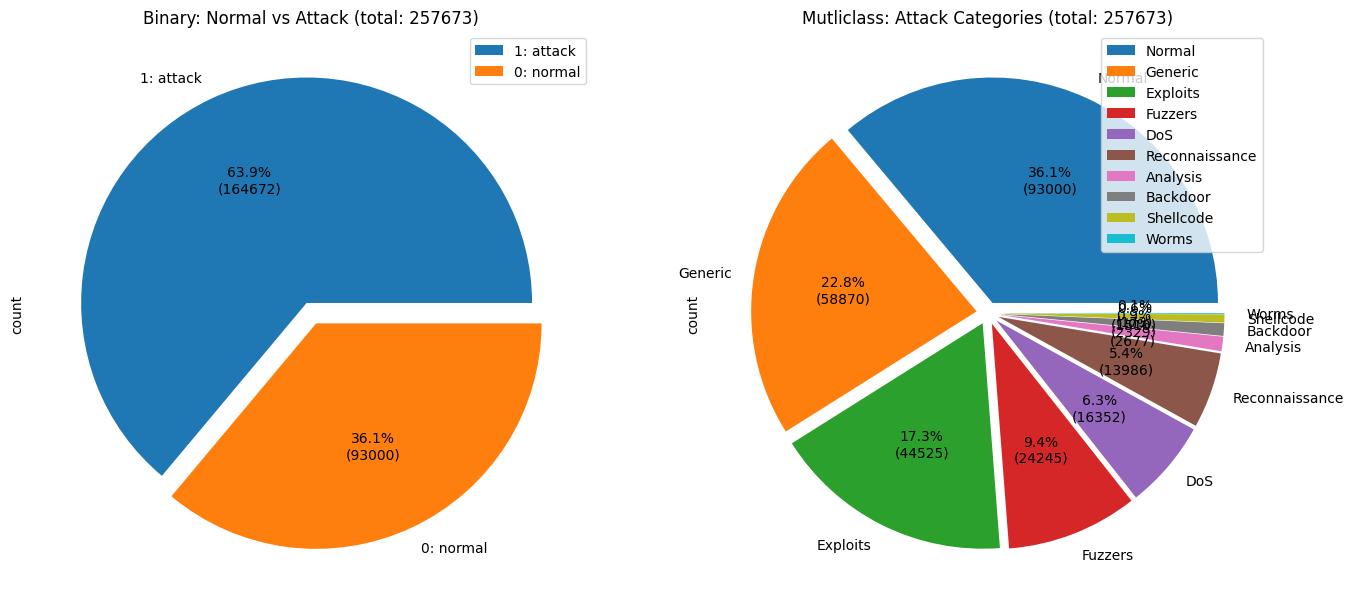

In [16]:
plot_data({'data': data['all'], 'col':'label', 'plt_type': 'pie', 'title': 'Binary: Normal vs Attack', 'labels':['1: attack', '0: normal']}, 
          {'data': data['all'], 'col':'attack_cat', 'plt_type': 'pie', 'title': 'Mutliclass: Attack Categories'}, col_width_factor=8, col_height=20)

#### Categorical Features - Binary

Binary categorical features (bool flags):
- _is_ftp_login_ - if ftp accessed by user and password then 1 else 0. This feature has inccorect values: 2 and 4 - total 26(10+16) entries.
- _is_sm_ips_port_ - if source and destination ports are equal then 1 else 0.
- we can see that both have very close normal/attack counters when _is_ftp_login_, _is_sm_ips_port_ == 0

is_ftp_login          0           1  2   4
is_sm_ips_ports       0     1     0  0   0
label                                     
0                 88006  3678  1314  2   0
1                162744     0  1905  8  16


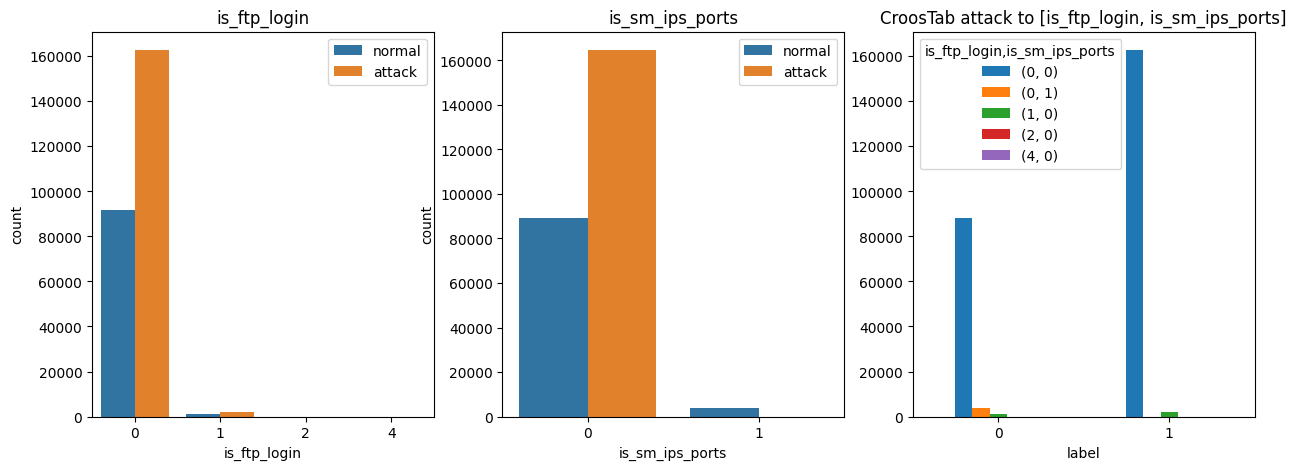

In [17]:
print(pd.crosstab(data['all']['label'], [data['all']['is_ftp_login'],data['all']['is_sm_ips_ports']]))
plot_data({'data': data['all'], 'col':['is_ftp_login', 'is_sm_ips_ports'], 'hue': 'label', 'plt_type': 'count', 'legend': {'labels': ['normal', 'attack']}},
          {'data': data['all'], 'col':'label', 'col_b': ['is_ftp_login', 'is_sm_ips_ports'], 'plt_type': 'crosstab', 'title': 'CroosTab attack to [is_ftp_login, is_sm_ips_ports]'})

#### Categorical Features - Nominal

- _proto_ - transaction protocol. UDP was attacked more than TCP. Many protocols such as UNAS, GRE, IPv6, etc. were under attack, but don't have normal traffic.
- _service_ - application layer protocols (OSI L7).
    - big portion of data is not classified '-'
    - normal/attack: DNS - ~1:6, HTTP - ~1:2
    - secure protocols such as SSH are less vulnarable for cyber attacks
- _state_ - protocol (TCP, UDP, ICMP) state, e.g. - initiating, finishes, request, etc.
    - FIN - end of data transmission in TCP 50:50 normal vs attack traffic. Has highter amount of normal data
    - INT - session initialization, high attack rate 1:10 (normal:attack)
    - CON - session connection maintance state, most of the data is normal
    - REQ - connection request - norma:attack ratio ~2:1
    - RST - session RST, doesn't have atacks only normal data

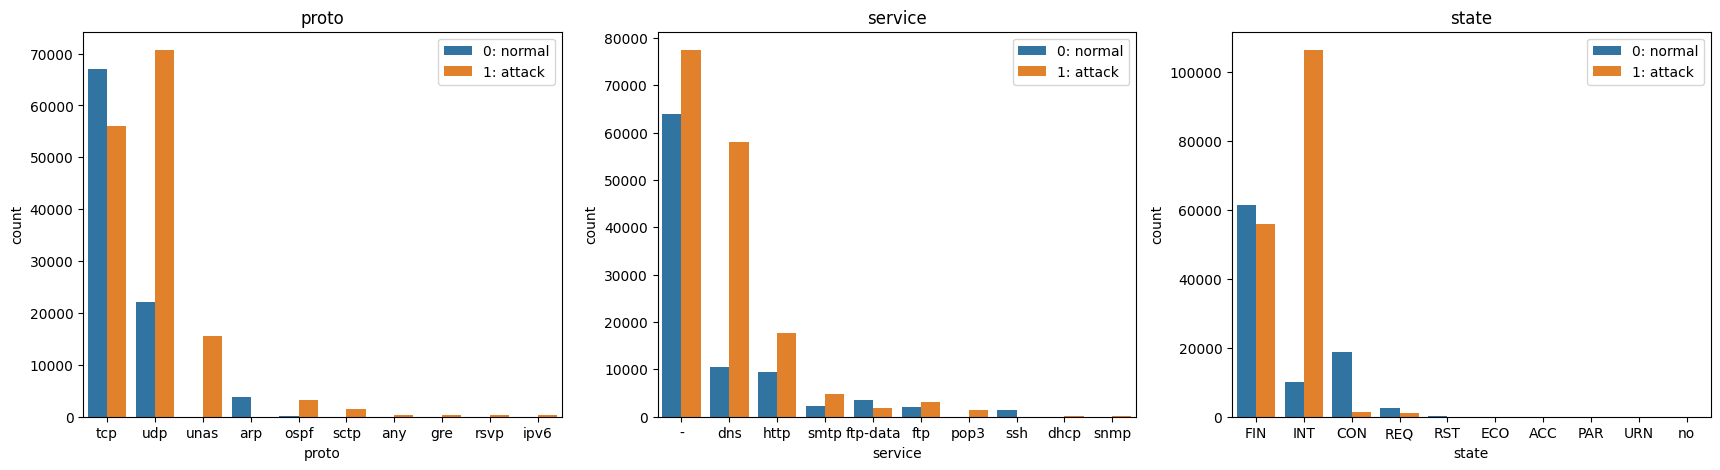

In [18]:
plot_data(*[{'data': data['all'], 'hue': 'label', 'plt_type': 'count', 'legend': {'labels': ['0: normal', '1: attack']}, 'col': c, 'order':data['all'][c].value_counts().iloc[:10].index } for c in ['proto', 'service', 'state']], col_width_factor=7)

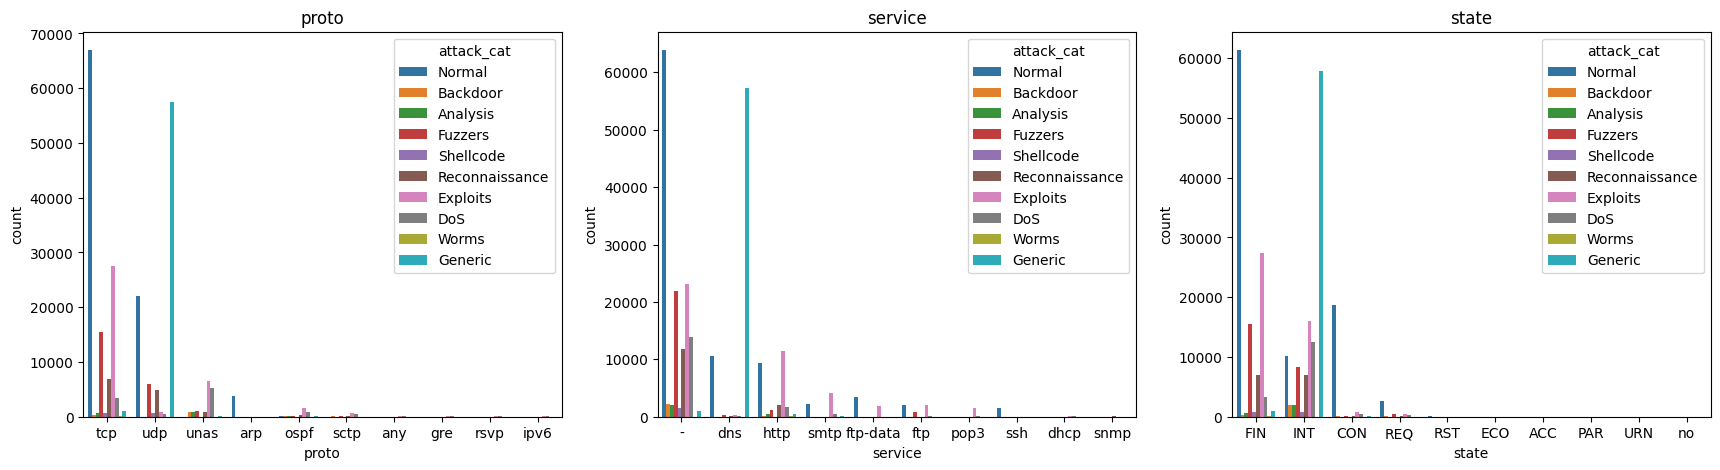

In [19]:
plot_data(*[{'data': data['all'], 'hue': 'attack_cat', 'plt_type': 'count', 'col': c, 'order':data['all'][c].value_counts().iloc[:10].index } for c in ['proto', 'service', 'state']], col_width_factor=7)

In [20]:
mask = (data['all']['attack_cat'] == 'Generic') & (data['all']['proto'] == 'udp') & (data['all']['service'] == 'dns') & (data['all']['state'] == 'INT')
print(pd.crosstab(data['all'].loc[mask, 'attack_cat'], [data['all'].loc[mask, 'proto'], data['all'].loc[mask,'service']]))

proto         udp
service       dns
attack_cat       
Generic     57276


#### Numerical Features - Integer (low value span)

Some of the features have integer representation but very low number of different values, which make them more suitable for categorical representation.
- _ct_state_ttl_ - No. for each state according to specific range of values for source/destination time to live.
- _ct_flw_http_mthd_ - No. of flows that has methods such as Get and Post in http service.
- _ct_ftp_cmd_ - No of flows that has a command in ftp session.

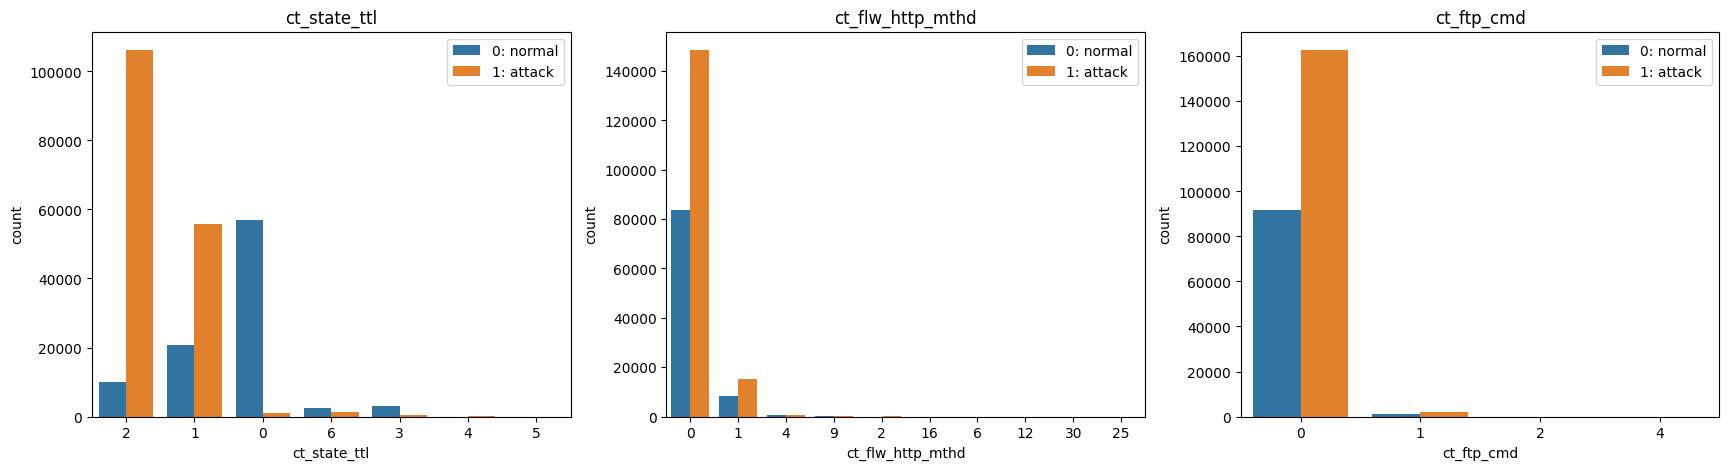

In [21]:
plot_data(*[{'data': data['all'], 'hue': 'label', 'plt_type': 'count', 'legend': {'labels': ['0: normal', '1: attack']}, 'col': c, 'order':data['all'][c].value_counts().iloc[:10].index } for c in ['ct_state_ttl', 'ct_flw_http_mthd', 'ct_ftp_cmd']], col_width_factor=7)

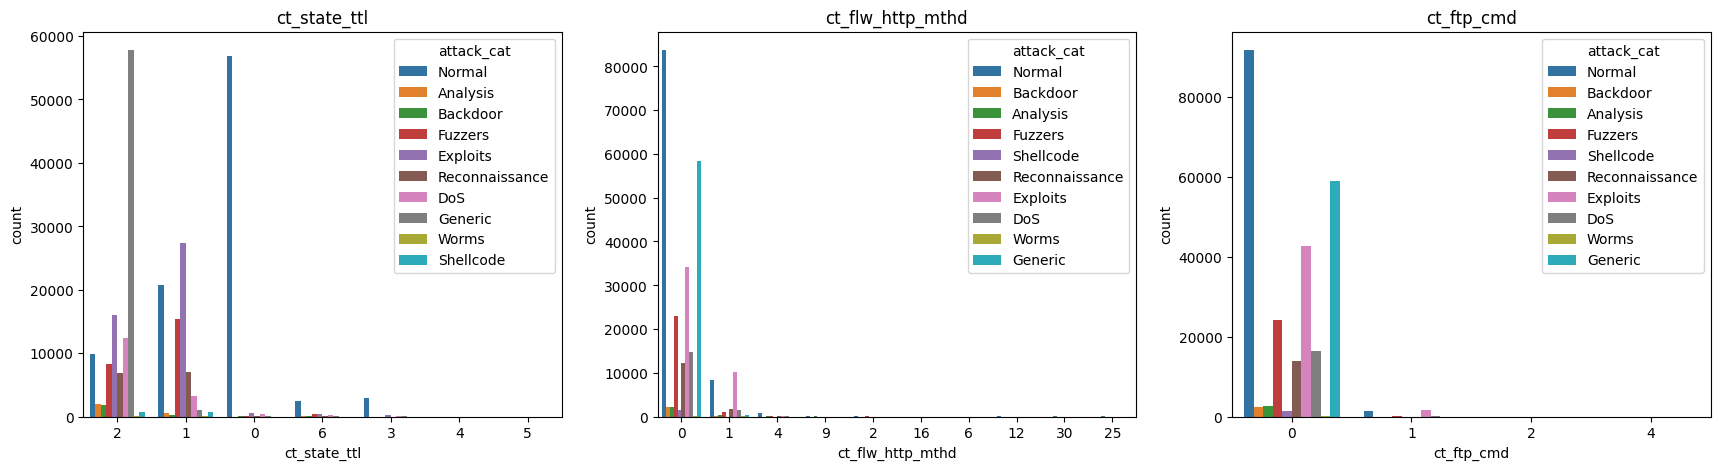

In [22]:
plot_data(*[{'data': data['all'], 'hue': 'attack_cat', 'plt_type': 'count', 'col': c, 'order':data['all'][c].value_counts().iloc[:10].index } for c in ['ct_state_ttl', 'ct_flw_http_mthd', 'ct_ftp_cmd']], col_width_factor=7)

In [23]:
for c in ['ct_state_ttl', 'ct_flw_http_mthd', 'ct_ftp_cmd']:
    display(data['all'][c].value_counts())

ct_state_ttl
2    116154
1     76589
0     57836
6      3734
3      3331
4        28
5         1
Name: count, dtype: int64

ct_flw_http_mthd
0     232253
1      23604
4       1324
9        216
2         92
16        48
6         42
12        36
30        30
25        25
3          3
Name: count, dtype: int64

ct_ftp_cmd
0    254426
1      3215
2        16
4        16
Name: count, dtype: int64

#### Numerical Continuous Features (Integer & Float)

In [24]:
data_numeric = data['all'].select_dtypes(include=np.number)
data_numeric.drop(columns=['id', 'label', 'is_sm_ips_ports', 'is_ftp_login', 'ct_state_ttl', 'ct_flw_http_mthd', 'ct_ftp_cmd'], inplace=True)

In [25]:
data_numeric['spkts'].unique()

array([    6,    14,     8,    12,    10,    62,     2,    24,    28,
          30,     1,    16,     4,    36,    22,   122,    38,    20,
          66,    78,    42,    52,    64,    40,    80,     3,    26,
         110,   106,   360,   354,   366,   352,   108,   362,    18,
         342,   332,   336,   308,   322,   328,   358,   224,   234,
         222,   208,   200,    68,    48,    90,   356,    70,   348,
         236,    92,   240,   452,   450,   368,   434,   420,   238,
         432,   288,   112,   650,   656,   364,   548,    50,   230,
         562,   372,   216,   204,    60,   228,   206,   350,   294,
         346,   232,    46,   226,   218,   296,   190,   286,    88,
         338,    32,   344,   326,   340,   318,   212,   242,   202,
         214,   324,   314,   292,   244,   284,    58,   334,   220,
         306,   290,   280,    11,    54,    34,    84,   128,    86,
         436,   422,   438,   414,   440,   126,   320,   198,   302,
         370,   130,

##### Numeric features/binary target histogram

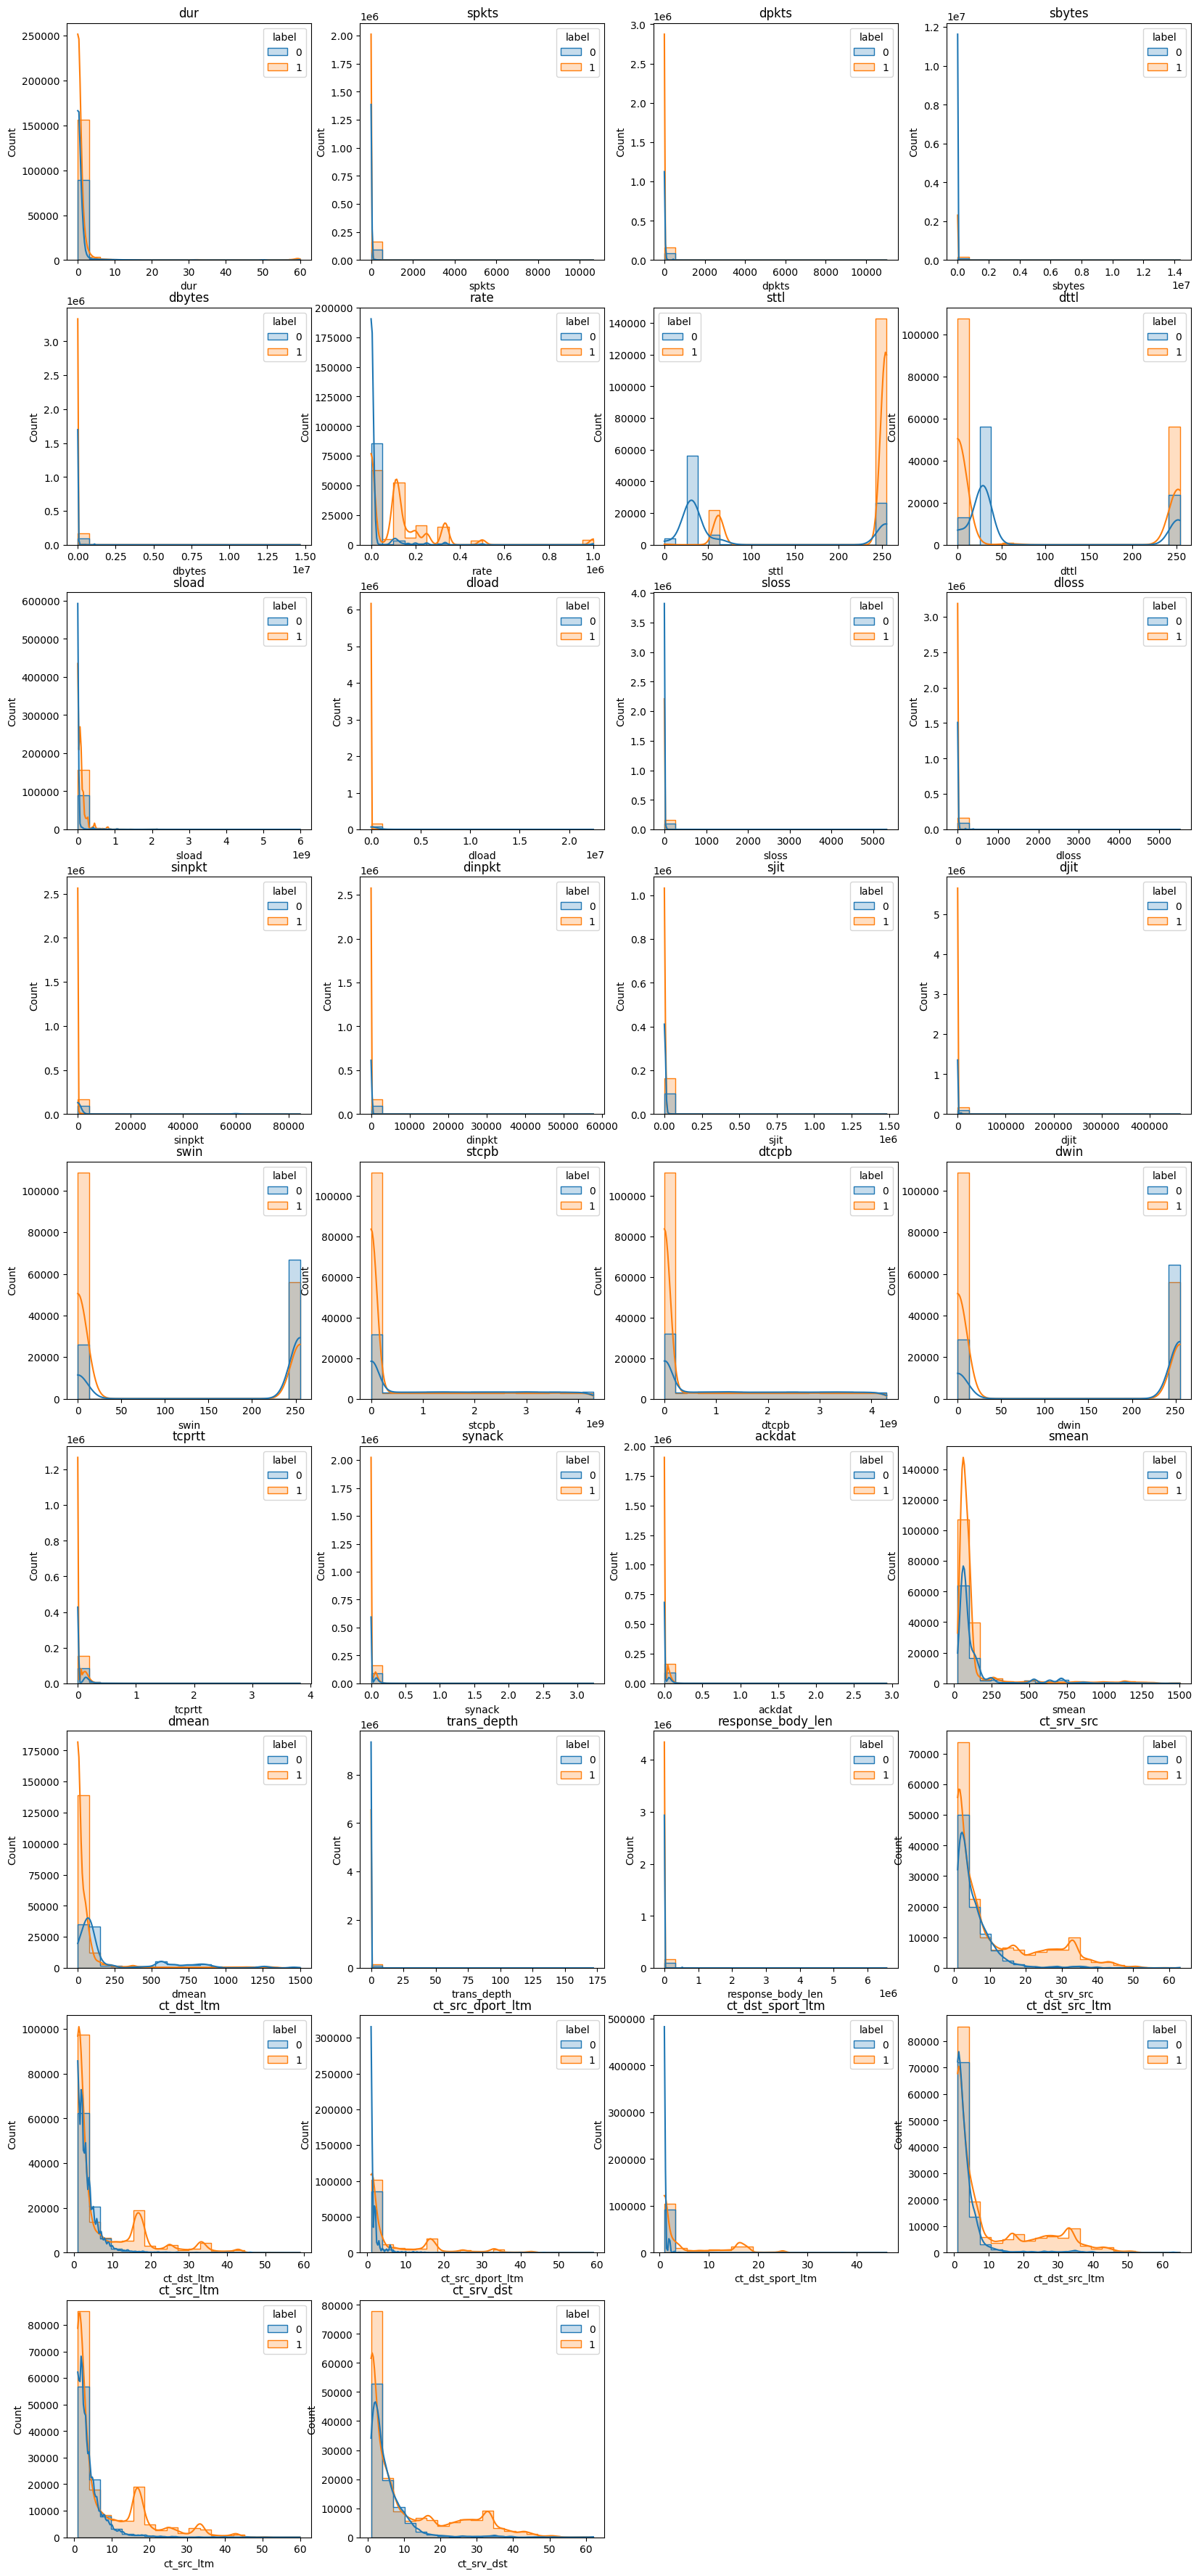

In [26]:
plot_data(*[{'data':data['all'], 'plt_type': 'hist', 'kde_flag':True, 'n_bins':20, 'col': c, 'hue': 'label'} for c in data_numeric])

##### Numeric features/multi-class target histogram

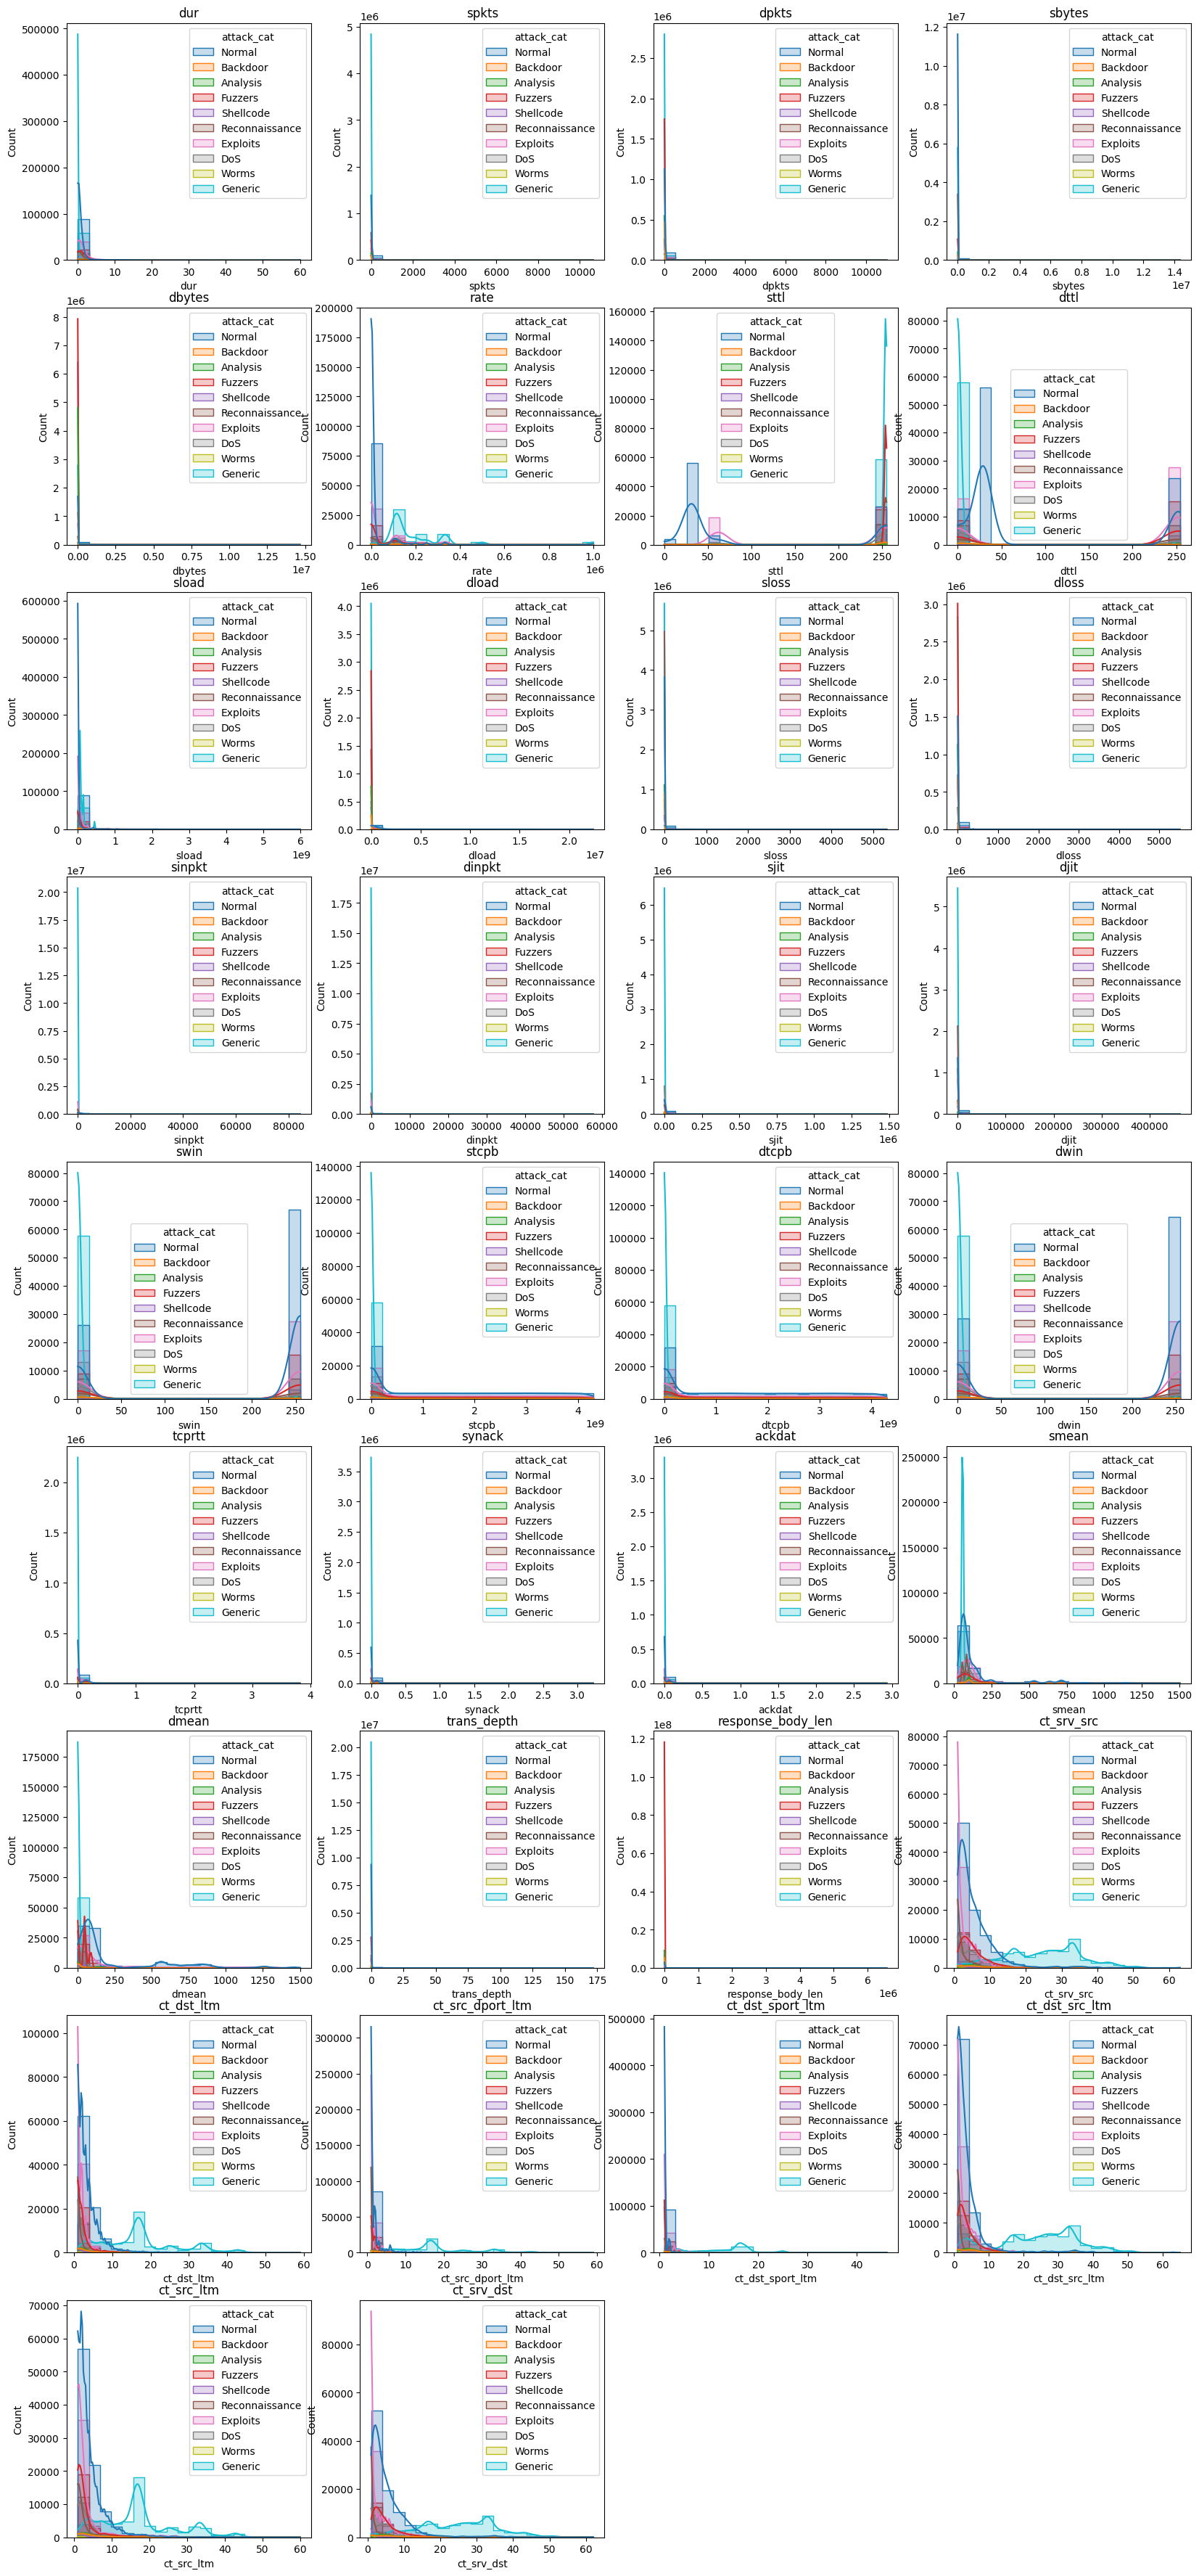

In [27]:
plot_data(*[{'data':data['all'], 'plt_type': 'hist', 'kde_flag':True, 'n_bins':20, 'col': c, 'hue': 'attack_cat'} for c in data_numeric])

##### Numeric features stats

**Arithmetic mean (average)** - sum of the values in dataset divided by total number of values
<ul>

$\overline{x}=\frac{1}{n} \sum_{i=1}^{n} x_{i}=\frac{1}{n}\left(x_{1}+\cdots+x_{n}\right)$
</ul>

**Median** - the middle value in a dataset when it is sorted in ascending or descending order
<ul>

if x is odd: $ med(x)=x_{(n+1)/2}$ , else: $ med(x)=\frac{x_{(n/2)} + x_{(n/2)+1}}{2}$
</ul>

**Standard deviation (STD)** - statistical measure of the dispersion or spread of data points from the mean
<ul>
Population:<br>

$ \sigma = \sqrt\frac{\sum_{i=1}^{N}(x_i-\mu)^2}{N}$ <br>
where, <br>
$\sigma$ - population STD <br>
$x_i$ - is individual value  
$\mu$ - population average  
N = population size  

Sample:<br>

$ \sigma = \sqrt\frac{\sum_{i=1}^{N}(x_i-\overline{x})^2}{N}$ <br>
where, <br>
$\sigma$ - sample STD <br>
$x_i$ - is individual value  
$\overline{x}$ - sample average  
N = sample size  
</ul>
<p align="left" style="margin-left:5em;">
    <img src="images/std.png" alt="IDS" width="25%" height="auto"/>
</p>

**Skewness** - measure of the assymetry of the probability distribution of numeric random variable abouts it's mean
* Negative skewness – mean less than median. Long tail on the left side, most of the data values concentrated on the right
* Zero skewness – data is simetrically distributed, equal length tails on both sides of the mean
* Positive skewness - mean greater than median. Long tail on the right, most of the data values concentrated on the left

<p align="left" style="margin-left:5em;">
    <img src="images/skewness.png" alt="IDS" width="25%" height="auto"/>
</p>

**Kurtosis** – measure shape and tail of data (3 – normal distribution, excess kurtosis 0)
* Platykurtic – low kurtosis (thin tails)
* Mesokurtic – medium kurtosis (medium tails)
* Leptokurtic – high kurtosis (fat tails)


<p align="left" style="margin-left:5em;">
    <img src="images/kurtosis.png" alt="IDS" width="25%" height="auto"/>
</p>

In [28]:
def get_numeric_stats(df, cols, transpose=False, format_function=None):
    num_stats = {}
    for c in cols:
        num_stats[c] = {
            'mean': df[c].mean(),
            'median': df[c].median(),
            'std': df[c].std(),
            'skew': df[c].skew(),
            'kurtosis':  df[c].kurt()
            }
        
    out_df = pd.DataFrame(num_stats)
    if transpose:
        out_df = out_df.T

    if format_function is not None:
        out_df = out_df.map(format_function)

    return out_df

In [29]:
format_function = lambda x: f'{x:.3f}' if isinstance(x, (int, float)) else x  # format numeric values - 3 digits after the floating point
num_stats = get_numeric_stats(data['all'], data_numeric, transpose=True, format_function=format_function)
display(num_stats)

mean      median             std     skew  \
dur                         1.247       0.004           5.974    8.022   
spkts                      19.777       4.000         135.947   42.522   
dpkts                      18.515       2.000         111.986   41.193   
sbytes                   8572.952     528.000      173773.881   47.917   
dbytes                  14387.288     178.000      146199.282   44.340   
rate                    91253.912    2955.665      160344.637    3.380   
sttl                      180.001     254.000         102.488   -0.682   
dttl                       84.755      29.000         112.762    0.787   
sload                70608691.228  743942.312   185731252.842    8.933   
dload                  658214.282    1747.441     2412372.138    4.711   
sloss                       4.889       0.000          65.575   47.121   
dloss                       6.744       0.000          53.702   46.086   
sinpkt                    912.301       0.382        6922.153    8.288   
dinpkt                     98.915       0.007        1094.049   26.965   
sjit                     5419.373       0.674       49034.496   16.865   
djit                      582.251       0.000        3930.153   37.496   
swin                      121.754       0.000         127.367    0.090   
stcpb              1006120340.178       0.000  1367794569.625    1.026   
dtcpb              1002295002.141       0.000  1363877092.421    1.031   
dwin                      119.255       0.000         127.230    0.130   
tcprtt                      0.046       0.000           0.093    7.435   
synack                      0.024       0.000           0.054   12.216   
ackdat                      0.022       0.000           0.046    8.074   
smean                     137.639      73.000         205.901    3.667   
dmean                     121.650      44.000         254.041    2.910   
trans_depth                 0.102       0.000           0.711  173.163   
response_body_len        1968.900       0.000       49625.234   78.477   
ct_srv_src                  9.383       5.000          10.830    1.638   
ct_dst_ltm                  6.050       2.000           8.174    2.262   
ct_src_dport_ltm            5.238       1.000           8.161    2.405   
ct_dst_sport_ltm            4.033       1.000           5.832    1.959   
ct_dst_src_ltm              8.323       3.000          11.121    1.762   
ct_src_ltm                  6.800       3.000           8.396    2.039   
ct_srv_dst                  9.121       4.000          10.875    1.656   

                    kurtosis  
dur                   68.042  
spkts               2213.269  
dpkts               2965.882  
sbytes              2616.499  
dbytes              3272.347  
rate                  14.980  
sttl                  -1.495  
dttl                  -1.337  
sload                136.971  
dload                 22.786  
sloss               2551.469  
dloss               3502.780  
sinpkt                67.381  
dinpkt               939.566  
sjit                 314.488  
djit                2638.487  
swin                  -1.992  
stcpb                 -0.434  
dtcpb                 -0.421  
dwin                  -1.983  
tcprtt               158.254  
synack               398.234  
ackdat               204.626  
smean                 13.695  
dmean                  8.261  
trans_depth        37927.610  
response_body_len   8513.817  
ct_srv_src             1.853  
ct_dst_ltm             5.097  
ct_src_dport_ltm       5.681  
ct_dst_sport_ltm       2.951  
ct_dst_src_ltm         2.078  
ct_src_ltm             4.086  
ct_srv_dst             1.875

##### Numeric features - correlation matrix

Importance of correlation matrix:
* Understanding of feature relationship: 0-weak, -1 strong negative, +1 strong positive
* Important for feature selection

In [30]:
# select numeric columns
temp_data = data['all'].select_dtypes(include=np.number)
temp_data.drop('id', axis=1, inplace=True)

##### Pearson correlation

Pearson correlation measures the strength and direction of the linear relationship between 2 numerical variables.

Reference:  [Pearson Correlation Coefficient (r) | Guide & Examples](https://www.scribbr.com/statistics/pearson-correlation-coefficient/)<br>
<i>Scribbr, Published on May 13, 2022 by Shaun Turney. Revised on February 10, 2024</i>

<p align="left" style="margin-left:5em;">
    <img src="images/pearson.png" alt="IDS" width="40%" height="auto"/>
</p>

| Pearson corr. coeficient (r) value | Degree of linear correlation  |
|:--------------------------|:----------|
| +1 |	perfect positivie |
| greater than +0.5 |	strong positive |
| between 0.3 and +0.5 | moderate positive |
| between 0 and +0.3 | weak positive |
| 0 | no linear correlation |
| between 0 and -0.3 | weak negative |
| between -0.3 and -0.5 | moderate negative |
| less than -0.5 | strong negative |
| -1 |	perfect negative |

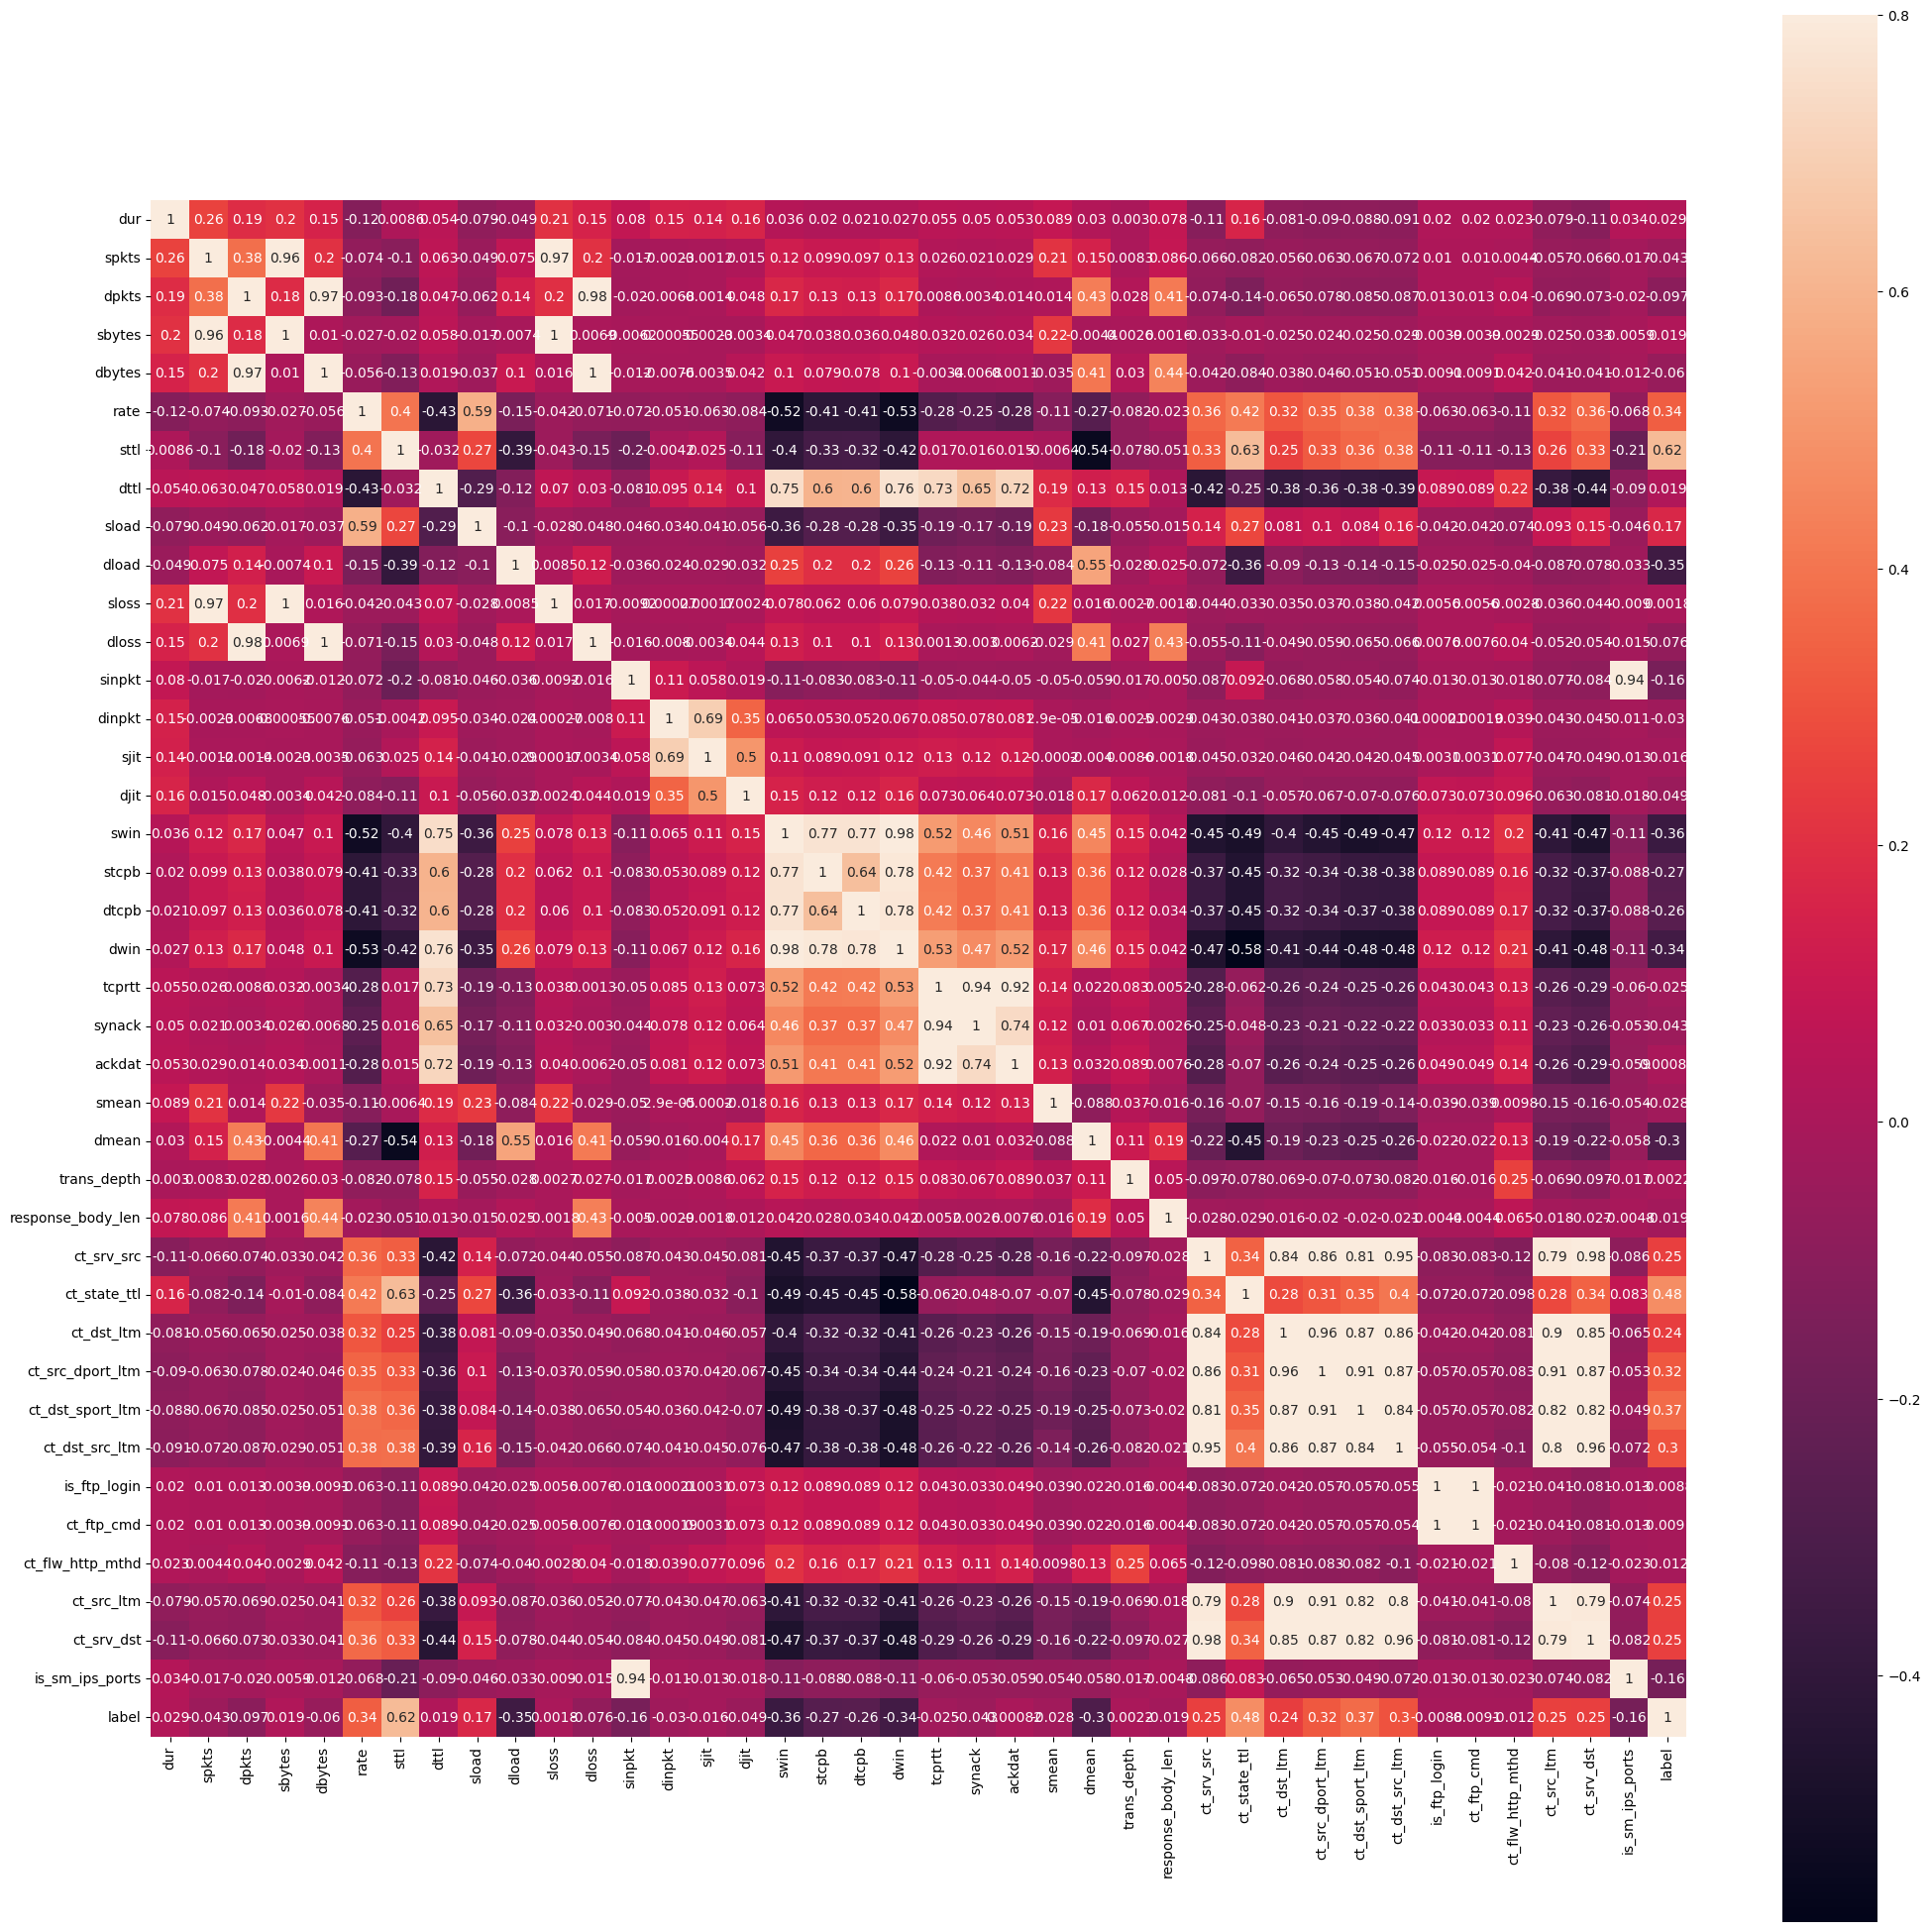

In [31]:
plt.figure(figsize=(25,25))
pearson_corr = temp_data.corr(method='pearson')
sns.heatmap(pearson_corr, annot=True, vmax=0.8,square = True)
plt.show()

In [32]:
def get_highly_correlated_features(corr_matrix, threshold=0.8, n=None, ascending=None):
    # get highly correlated feature pairs
    highly_correlated_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold:
                highly_correlated_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    # create a dataframe to store the results
    result_df = pd.DataFrame(highly_correlated_pairs, columns=['feature_a', 'feature_b', 'correlation'])
    if ascending is not None:
        # sort the data frame ascending(True) or descending(False)
        result_df = result_df.sort_values(by='correlation', ascending=ascending)
    
    if n is not None:
         result_df = result_df.head(n)

    return result_df

Pearson correlation - highly correlated features (pearson corr. coeficient >= 0.8)

In [33]:
pearson_high_corr_features = get_highly_correlated_features(pearson_corr, ascending=False)
display(pearson_high_corr_features)

feature_a         feature_b  correlation
19        ct_ftp_cmd      is_ftp_login     0.998855
5              dloss            dbytes     0.996711
3              sloss            sbytes     0.995772
6               dwin              swin     0.980458
4              dloss             dpkts     0.979612
24        ct_srv_dst        ct_srv_src     0.979467
1             dbytes             dpkts     0.973445
2              sloss             spkts     0.971859
0             sbytes             spkts     0.964393
11  ct_src_dport_ltm        ct_dst_ltm     0.961518
28        ct_srv_dst    ct_dst_src_ltm     0.960321
15    ct_dst_src_ltm        ct_srv_src     0.953952
7             synack            tcprtt     0.943053
29   is_sm_ips_ports            sinpkt     0.942121
8             ackdat            tcprtt     0.920218
21        ct_src_ltm  ct_src_dport_ltm     0.909430
14  ct_dst_sport_ltm  ct_src_dport_ltm     0.908337
20        ct_src_ltm        ct_dst_ltm     0.901582
17    ct_dst_src_ltm  ct_src_dport_ltm     0.871847
13  ct_dst_sport_ltm        ct_dst_ltm     0.871118
26        ct_srv_dst  ct_src_dport_ltm     0.866717
10  ct_src_dport_ltm        ct_srv_src     0.861855
16    ct_dst_src_ltm        ct_dst_ltm     0.857494
25        ct_srv_dst        ct_dst_ltm     0.853085
9         ct_dst_ltm        ct_srv_src     0.840995
18    ct_dst_src_ltm  ct_dst_sport_ltm     0.836422
27        ct_srv_dst  ct_dst_sport_ltm     0.822873
22        ct_src_ltm  ct_dst_sport_ltm     0.817747
12  ct_dst_sport_ltm        ct_srv_src     0.814856
23        ct_src_ltm    ct_dst_src_ltm     0.802551

##### Spearman correlation

Spearman's correlation measures the strength of a monotonic relationship between 2 numeric variables

Reference:  [Spearman’s correlation (statstutor)](https://www.statstutor.ac.uk/resources/uploaded/spearmans.pdf)

<p align="left" style="margin-left:5em;">
    <img src="images/spearman.png" alt="IDS" width="40%" height="auto"/>
</p>

| Spearman corr. coeficient (r) value | Degree of monotonic correlation  |
|:--------------------------|:----------|
| +1 | perfect positivie |
| greater than +0.8 | very strong positive |
| between +0.6 and +0.8 | strong positive |
| between +0.4 and +0.6 | moderate positive |
| between +0.2 and +0.4 | weak positive |
| between 0 and +0.2 | very weak positive |
| 0 | no monotonic correlation |
| between 0 and -0.2 | very weak negative |
| between -0.2 and -0.4 | weak negative |
| between -0.4 and -0.6 | moderate negative |
| between -0.6 and -0.8 | strong negative |
| less than -0.8 | very strong negative |
| -1 |	perfect negative |

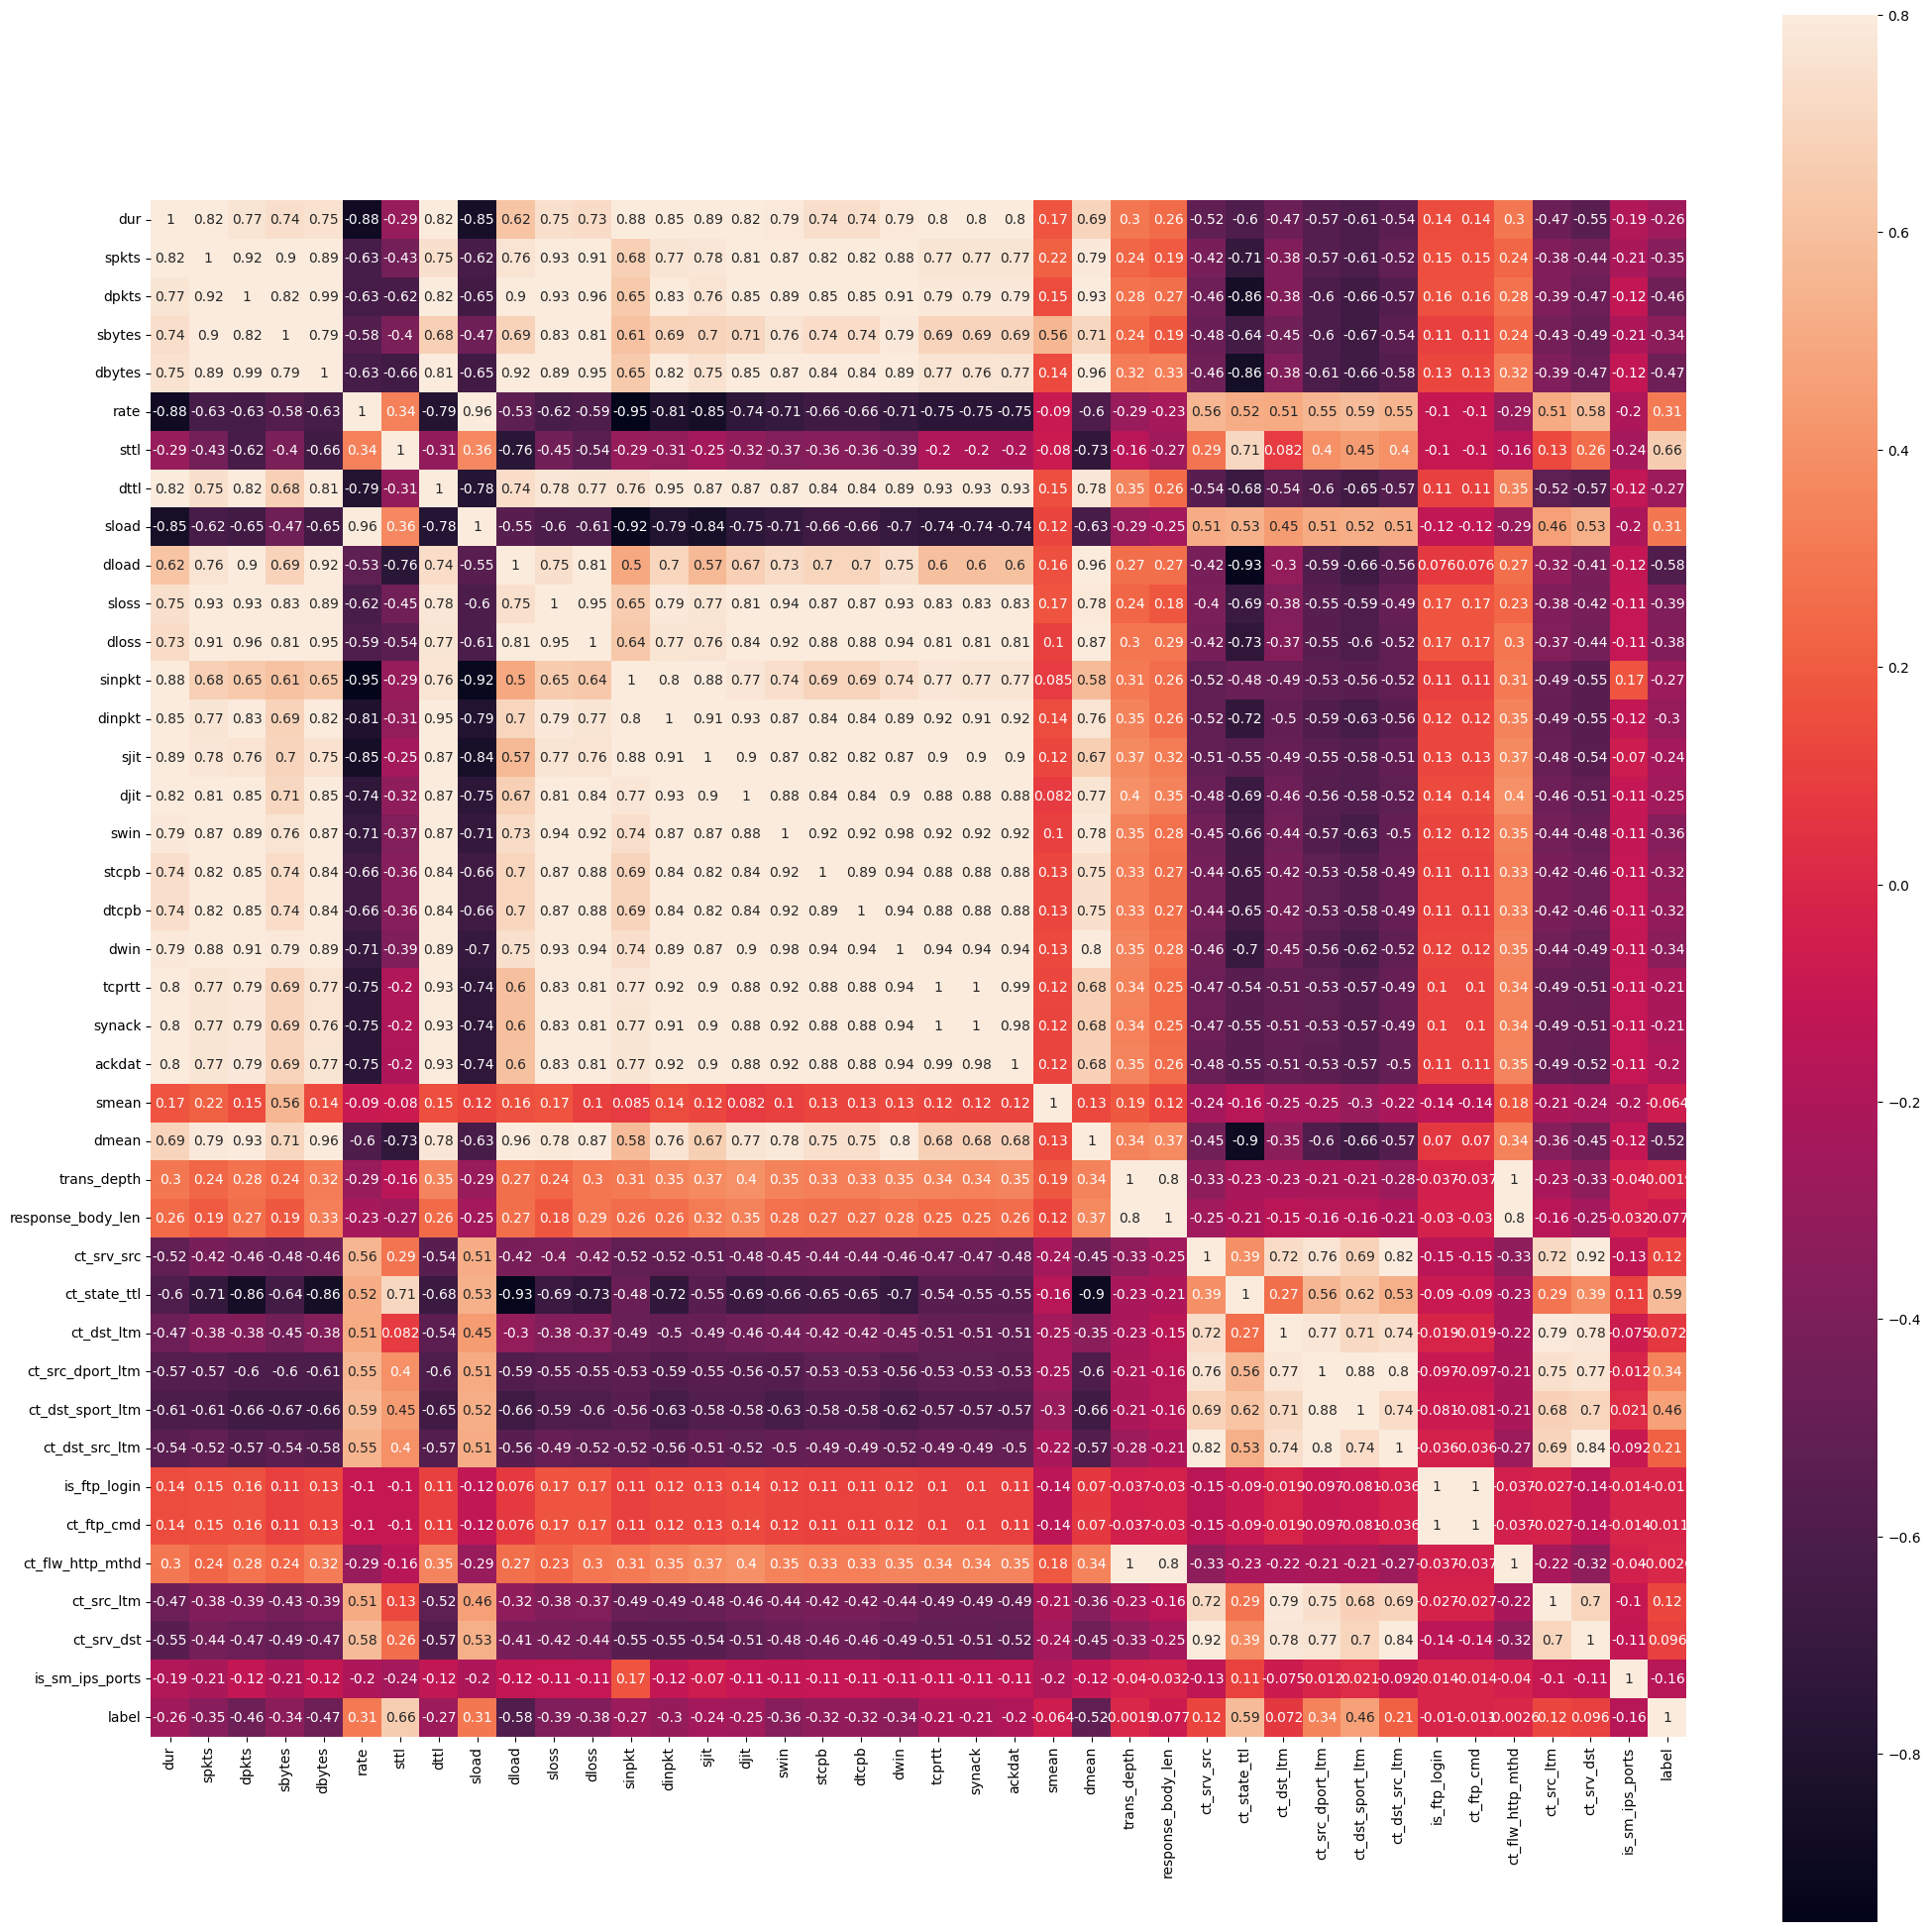

In [34]:
plt.figure(figsize=(25,25))
spearman_corr = temp_data.corr(method='spearman')
sns.heatmap(spearman_corr, annot=True, vmax=0.8,square = True)
plt.show()

Spearman correlation - highly correlated features
* spearman correllation coeficient >= 0.8
* top n correlations (n=20)

In [35]:
spearman_high_corr_features = get_highly_correlated_features(spearman_corr, ascending=False, n=20)
display(spearman_high_corr_features)

feature_a     feature_b  correlation
136        ct_ftp_cmd  is_ftp_login     0.999688
137  ct_flw_http_mthd   trans_depth     0.999563
110            synack        tcprtt     0.996267
122            ackdat        tcprtt     0.992658
5              dbytes         dpkts     0.989424
123            ackdat        synack     0.981722
86               dwin          swin     0.980518
126             dmean         dload     0.963142
125             dmean        dbytes     0.960883
11              sload          rate     0.959917
19              dloss         dpkts     0.957333
31             dinpkt          dttl     0.953303
21              dloss        dbytes     0.947647
23              dloss         sloss     0.946474
51               swin         sloss     0.937824
88               dwin         dtcpb     0.937687
87               dwin         stcpb     0.937514
82               dwin         dloss     0.936212
109            synack          dwin     0.936154
99             tcprtt          dwin     0.936148

##### Numeric features - scatter plot

Used for:
* correlation strong/weak
* type or correlation - linerar, non-linear
* identify outliers
* distribution understand - spread, cluster

Top 10 highly Pearson correlated feature pairs

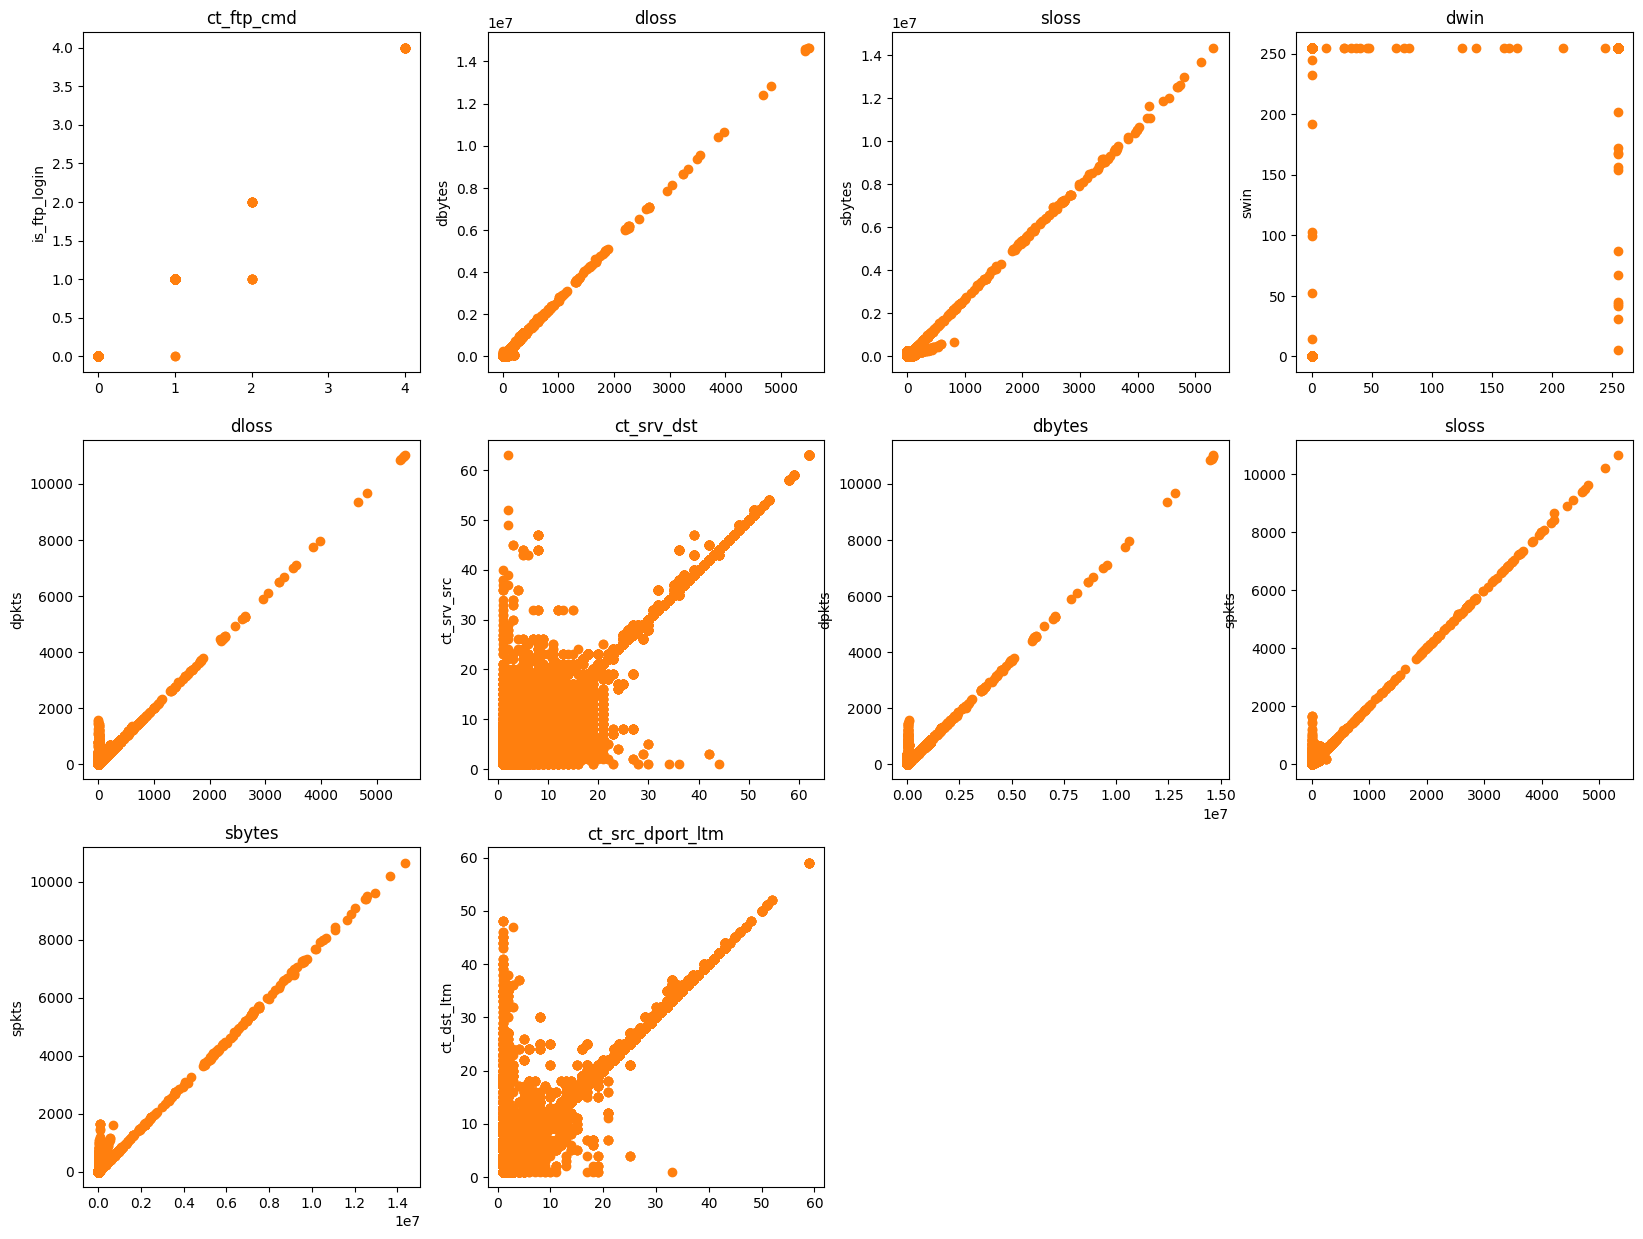

In [36]:
pearson_high_corr_top_n = pearson_high_corr_features.head(10).reset_index()
plot_data(*[{'data': temp_data, 'plt_type': 'scatter', 'col': row['feature_a'], 'y': row['feature_b']} for i, row in pearson_high_corr_top_n.iterrows()])

Top 10 highly Spearman correlated feature pairs

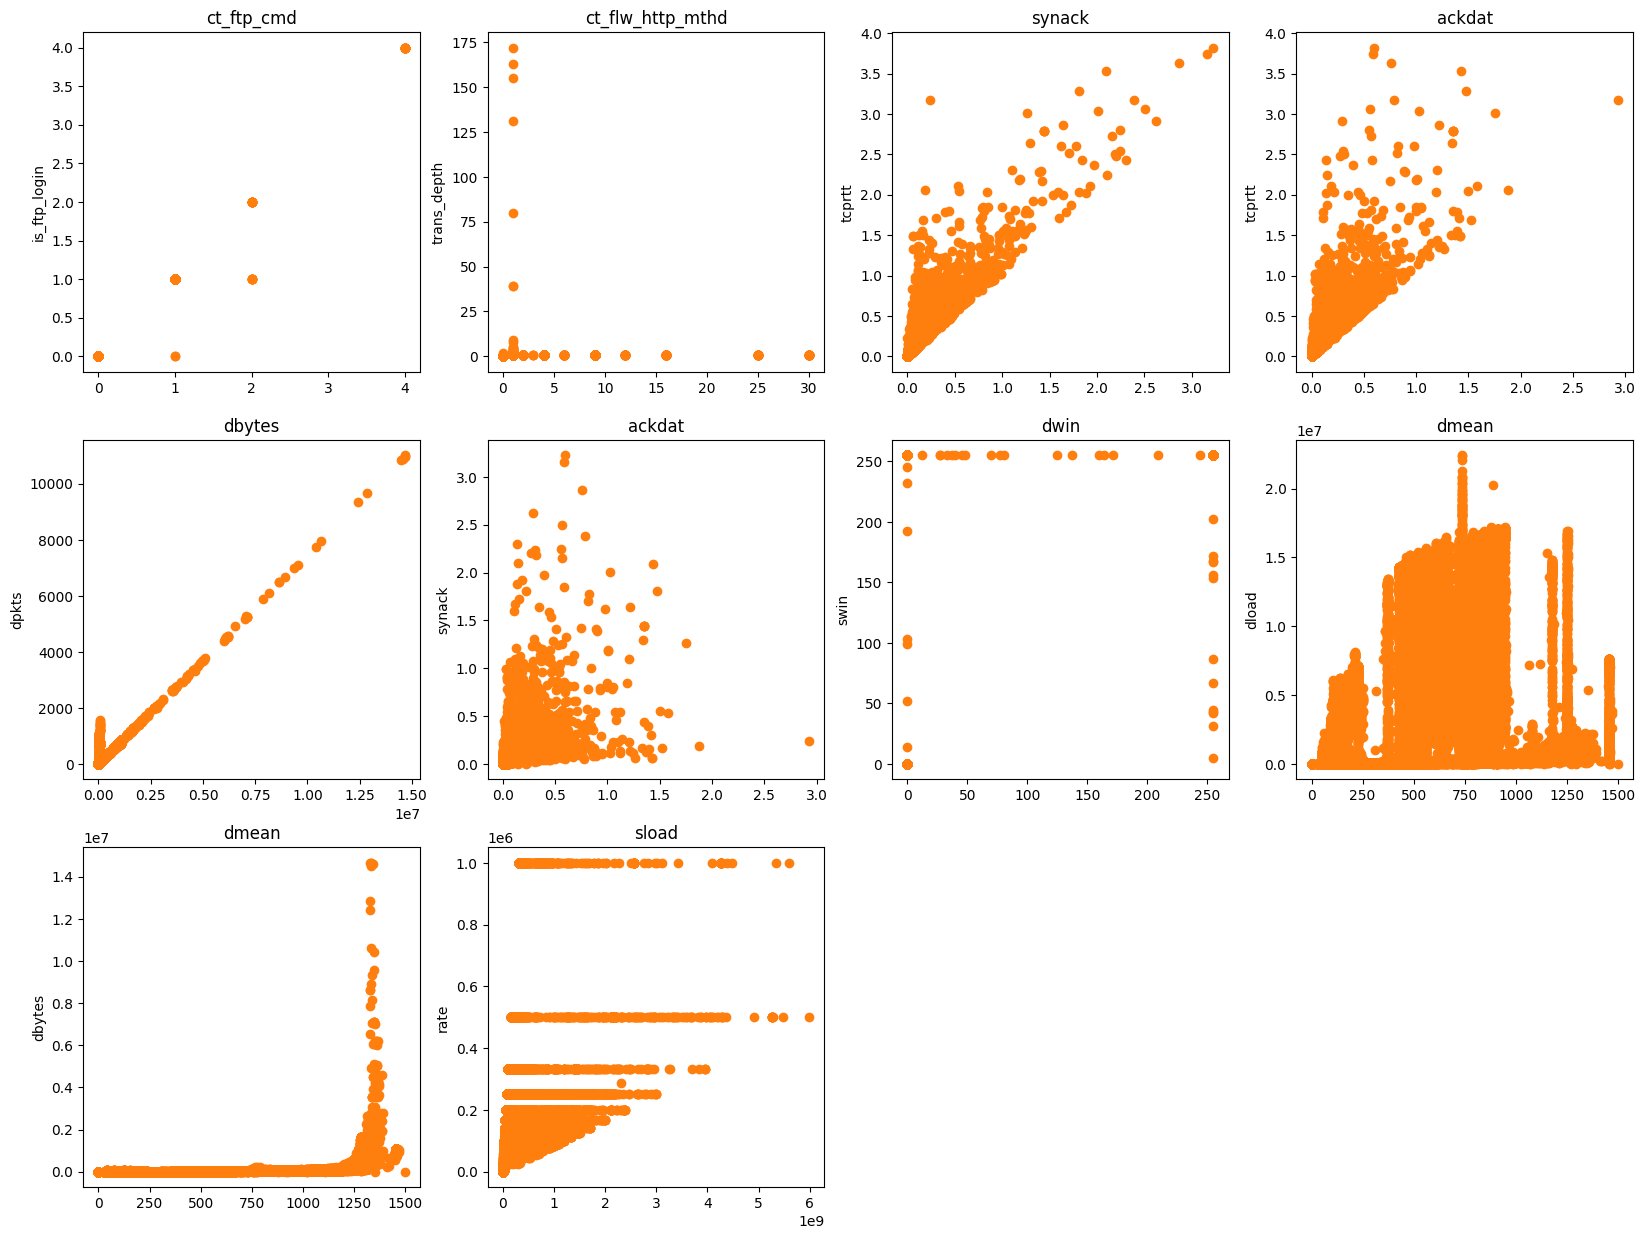

In [37]:
spearman_high_corr_top_n = spearman_high_corr_features.head(10).reset_index()
plot_data(*[{'data': temp_data, 'plt_type': 'scatter', 'col': row['feature_a'], 'y': row['feature_b']} for i, row in spearman_high_corr_top_n.iterrows()])

##### Numeric features - box plot IQR distribution of numeric features

Numeric features with binary target

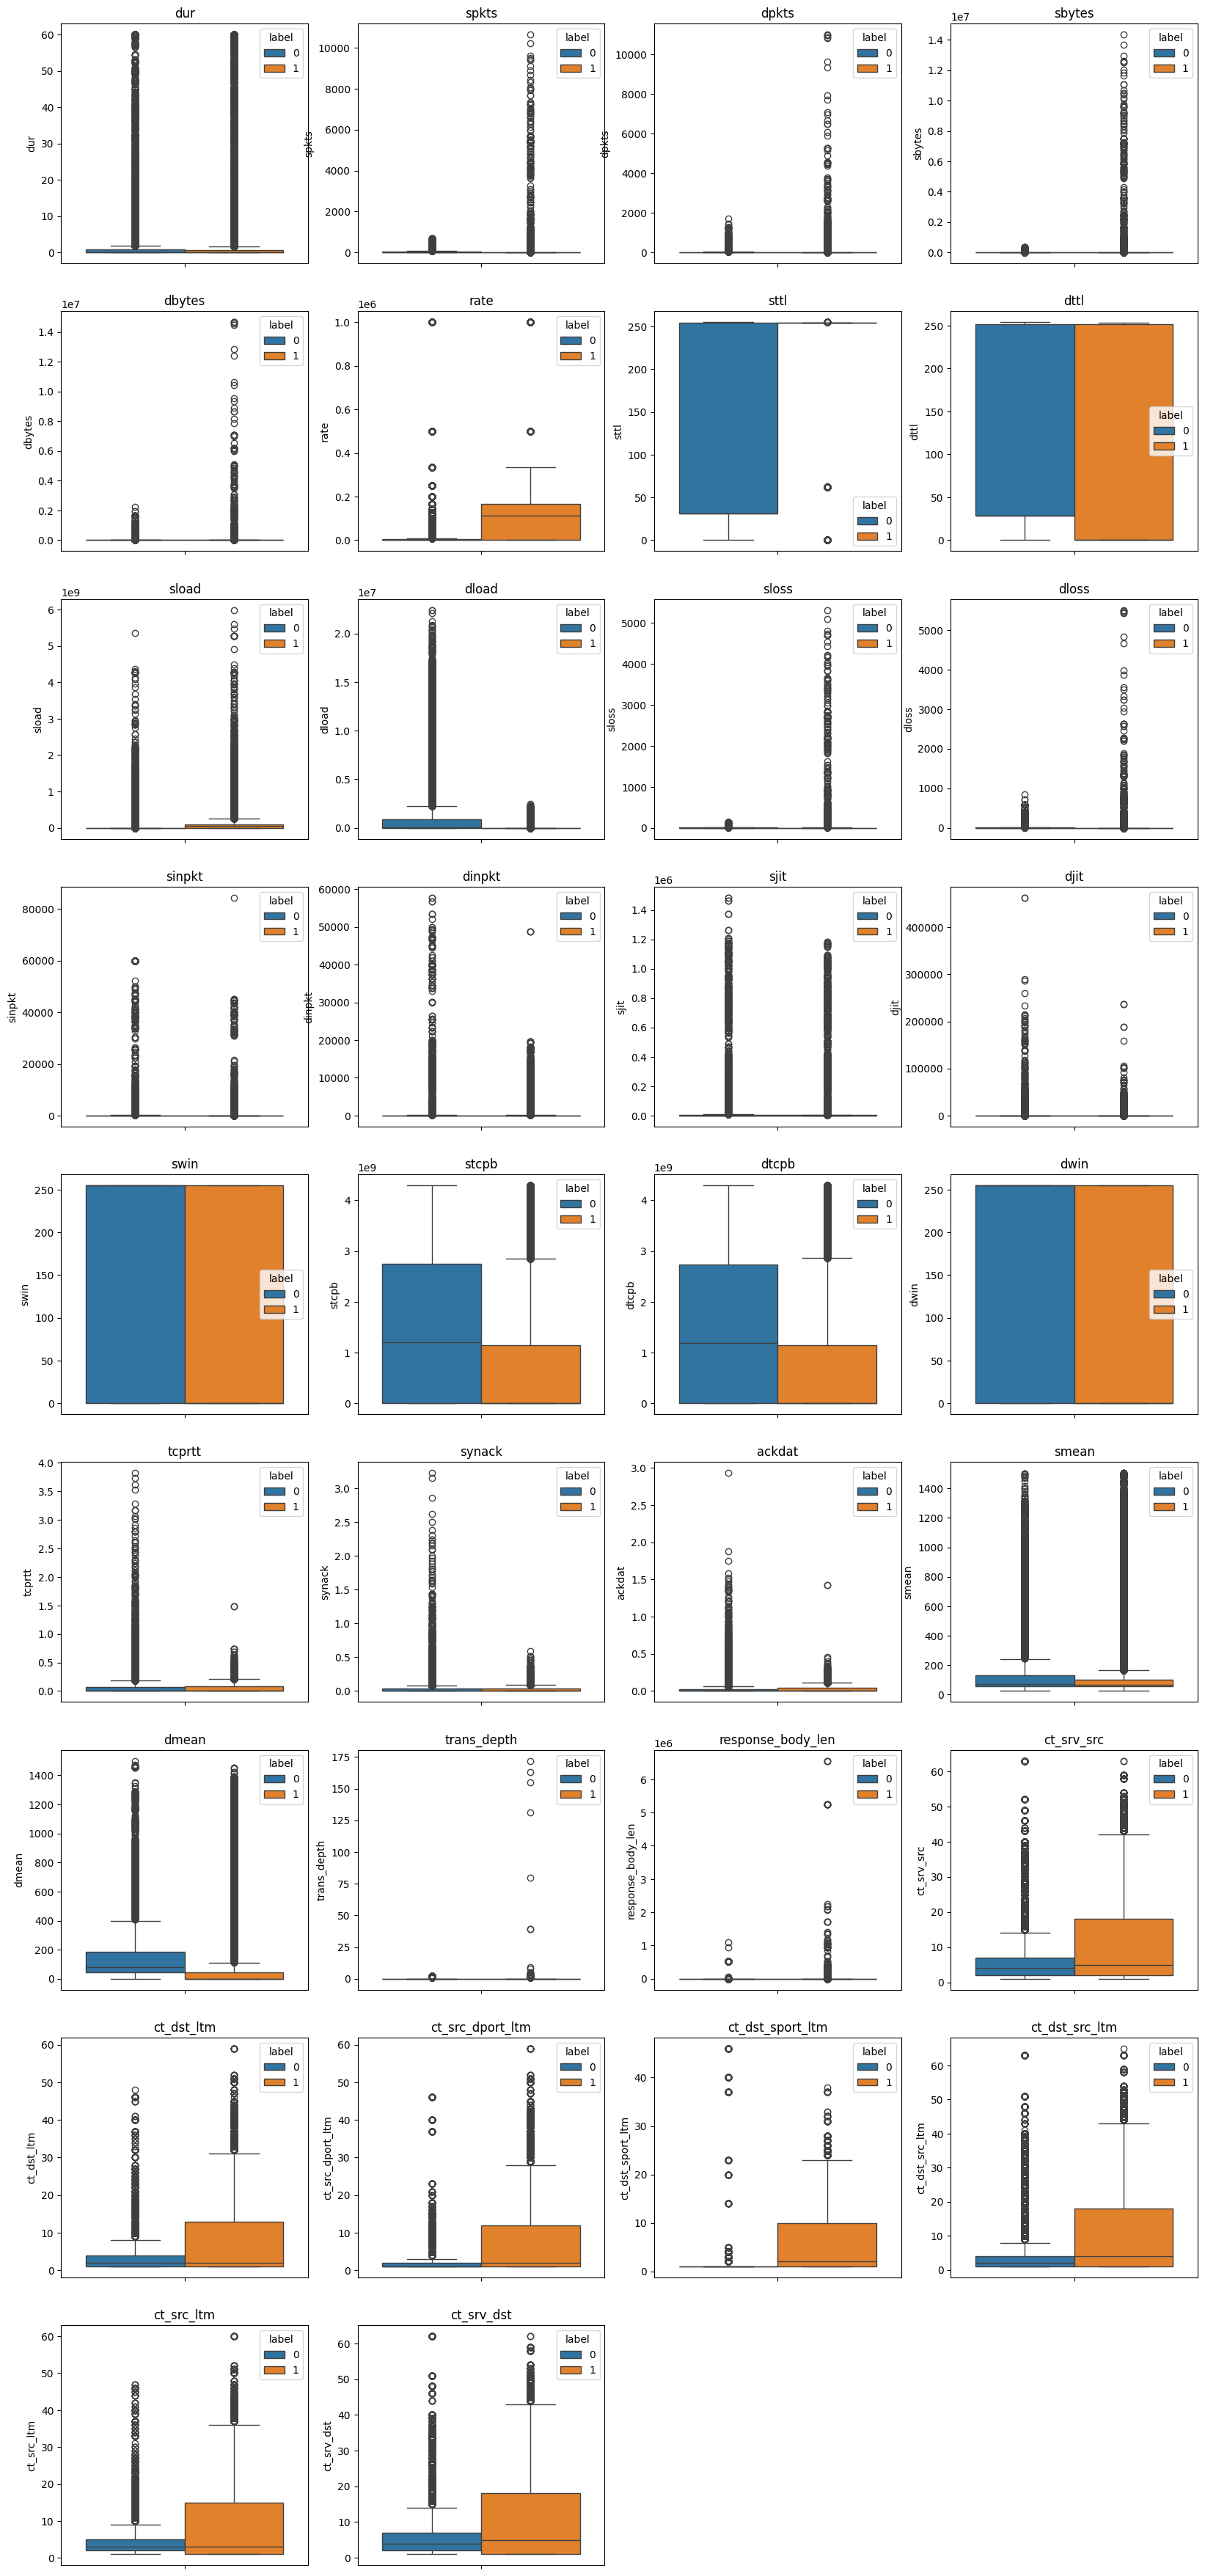

In [38]:
plot_data(*[{'data': data['all'], 'plt_type': 'box', 'col': c, 'hue': 'label'} for c in data_numeric])

Numeric features with mutliclass target

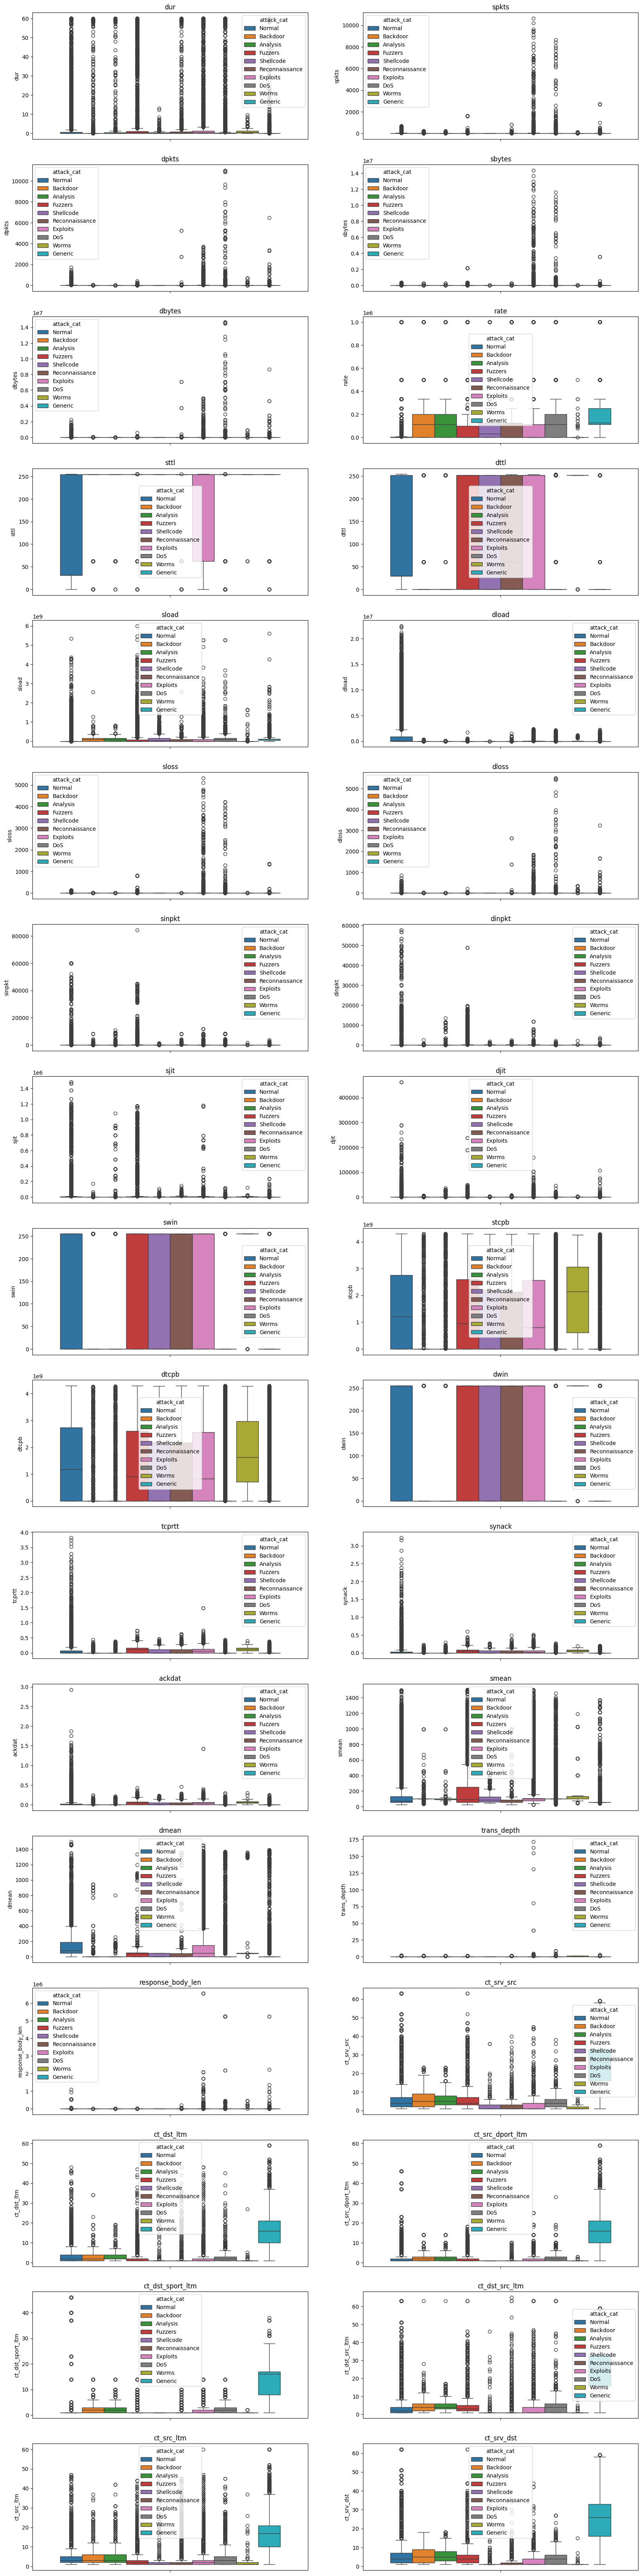

In [39]:
plot_data(*[{'data': data['all'], 'plt_type': 'box', 'col': c, 'hue': 'attack_cat'} for c in data_numeric], n_cols=2, col_width_factor=10)

# 5. Preprocessing

In [40]:
def count_duplicate_rows(df, columns=None, keep='first'):
    res = df.duplicated(subset=None if columns is None else columns, keep=keep).sum()
    print(f'Number of duplicated rows: {res}')
    return res

def handle_duplicate_rows(df, columns=None, keep='first'):
    dup_rows_cnt = count_duplicate_rows(df, columns=columns, keep=keep)
    if dup_rows_cnt > 0:
        print(f'DataFrame rows before drop: {df.shape[0]}')
        df_res = df.drop_duplicates(subset=columns if columns else None, keep=keep)
        print(f'DataFrame rows after drop: {df_res.shape[0]}')
        return df_res
    else:
        print('No duplicate rows (nothing dropped)')
        return df.copy()
    
def remove_corrupted_rows(df, miss_cols_threshold=3):
    func_name = 'remove_corrupted_rows'
    n_rows_before = df.shape[0]
    # drop rows with more than miss_cols_threshold NaN values
    df_res = df.dropna(thresh=len(df.columns) - miss_cols_threshold, inplace=False)
    print(f'{func_name}: Number of rows before: {n_rows_before}, after dropping corrupted: {df_res.shape[0]}')
    return df_res

def fill_missing_values(df):
    """
    fill NaNs - numeric with median value, object with most frequent
    """
    df_cp = df.copy()
    for c in df_cp.columns:
        if pd.api.types.is_numeric_dtype(df_cp[c]):
            df[c] = df_cp[c].fillna(df_cp[c].median())
        else:
            df[c] = df_cp[c].fillna(df_cp[c].mode()[0])
    return df_cp

def outlier_handling_iqr(df, features):
    func_name = "outlier_handling_iqr"
    iqr_factor = 1.5
    df_res = df.copy()
    print(f"{func_name}: DF before: ", df_res.isnull().sum().sum(), ' nulls')
    # Replace numeric outliers with np.nan
    for col in features:
            
        # calculate Q1 and Q3 for each column
        Q1 = df_res[col].quantile(0.25)
        Q3 = df_res[col].quantile(0.75)
        
        # interquatile range (IQR)
        IQR = Q3 - Q1
        
        # replace outliers with NaN
        df_res.loc[(df_res[col] < (Q1 - iqr_factor * IQR)) | (df_res[col] > (Q3 + iqr_factor * IQR)), col] = np.nan
            
    print("{func_name}: DF after: ", df_res.isnull().sum().sum(), ' nulls')
    return df_res

##### Remove corrupted and duplicate rows

In [41]:
data2 = data['all'].copy()
data2.drop(['id'], axis=1, inplace=True)

##### Handle missing values

In [42]:
# remove duplicate rows
data2 = handle_duplicate_rows(data2)

# remove corrupted rows
data2 = remove_corrupted_rows(data2, 3)

Number of duplicated rows: 94928
DataFrame rows before drop: 257673
DataFrame rows after drop: 162745
remove_corrupted_rows: Number of rows before: 162745, after dropping corrupted: 162745


##### Fill Missing Values

In [43]:
data2 = fill_missing_values(data2)
print(data2.isnull().sum().to_string())

dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat           0
label      

##### Drop highly correlated features
References:
1. [All about Feature Selection](https://medium.com/@chandradip93/all-about-feature-selec-e6e88e8ccd46)<br>
<i>By Chandradip Banerjee, Medium, Mar 6 2023</i>
2. [Why we have to remove highly correlated features in Machine Learning?](https://medium.com/@sujathamudadla1213/why-we-have-to-remove-highly-correlated-features-in-machine-learning-9a8416286f18)<br>
<i>By Sujatha Mudadla, Medium, Nov 29, 2023</i>

* Redundancy
* Multicollinearity – may affect linear models
* Computation efficiency
* Model interpretability – complex to interpret importance of highly correlated features
* Feature importance stability – small change in dataset can lead to significant variations in feature importance 

In [44]:
temp_data = data['train'].select_dtypes(include=np.number)
temp_data.drop('id', axis=1, inplace=True)

In [45]:
# select highly correlated features
corr_matrix = temp_data.corr().abs()
# select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"Columns to drop:\n{to_drop}")

Columns to drop:
['sbytes', 'dbytes', 'sloss', 'dloss', 'dwin', 'ct_src_dport_ltm', 'ct_dst_src_ltm', 'ct_ftp_cmd', 'ct_srv_dst']


# 6. Feature Engineering

In [46]:
# combine source and destination bytes
data2['sd_bytes'] = data2['sbytes'] + data2['dbytes']

Drop highly correlated columns

In [47]:
data2.drop(to_drop, axis=1, inplace=True)

Most of the numerical data is not symmetrically distibuted (see EDA - numerical stats and hist plots).<br>
To deal with skewed data we'll apply logarithmic function log1p.

References: 
* [Building an Intrusion Detection System on UNSW-NB15 Dataset Based on Machine Learning Algorithm](https://medium.com/@subrata.maji16/building-an-intrusion-detection-system-on-unsw-nb15-dataset-based-on-machine-learning-algorithm-16b1600996f5)<br>
<i> By Subrata Maji. Medium, Sep 19, 2020</i>
* [Understanding np.log and np.log1p in NumPy](https://medium.com/@noorfatimaafzalbutt/understanding-np-log-and-np-log1p-in-numpy-99cefa89cd30)<br>
<i> By Noor Fatima. Medium, Jun 28, 2024

In [48]:
temp_data = data2.select_dtypes(include=np.number)
temp_data.drop(columns=['label', 'is_sm_ips_ports', 'is_ftp_login', 'ct_state_ttl', 'ct_flw_http_mthd', 'ct_ftp_cmd'], inplace=True, errors='ignore')
num_stats_2 = get_numeric_stats(data2, temp_data, transpose=True)
display(num_stats_2)

mean        median           std        skew  \
dur                1.252714e+00  3.289570e-01  5.093951e+00    8.969246   
spkts              2.860947e+01  1.000000e+01  1.689001e+02   34.557395   
dpkts              2.851158e+01  8.000000e+00  1.378713e+02   33.923968   
rate               3.880025e+04  8.185405e+01  1.159475e+05    5.333270   
sttl               1.465986e+02  6.200000e+01  1.074557e+02   -0.019312   
dttl               1.257625e+02  2.900000e+01  1.167039e+02    0.140641   
sload              4.864382e+07  6.873062e+04  2.059415e+08    9.392226   
dload              1.038744e+06  6.931899e+03  2.968526e+06    3.620265   
sinpkt             3.661758e+02  2.153021e+01  3.947324e+03   14.340030   
dinpkt             1.087680e+02  1.361063e+01  1.100116e+03   28.933844   
sjit               5.613373e+03  1.248917e+03  4.328560e+04   19.058202   
djit               7.532242e+02  6.240216e+01  4.511877e+03   36.300247   
swin               1.829944e+02  2.550000e+02  1.147841e+02   -0.966894   
stcpb              1.521524e+09  1.264115e+09  1.429851e+09    0.408050   
dtcpb              1.515691e+09  1.250111e+09  1.426556e+09    0.414069   
tcprtt             6.831653e-02  7.550000e-04  1.068590e-01    6.810155   
synack             3.510803e-02  6.010000e-04  6.300115e-02   11.255566   
ackdat             3.320849e-02  1.530000e-04  5.269181e-02    7.379769   
smean              1.699796e+02  8.100000e+01  2.452209e+02    2.907764   
dmean              1.866946e+02  7.000000e+01  2.966666e+02    2.202026   
trans_depth        1.559372e-01  0.000000e+00  8.812827e-01  143.009686   
response_body_len  3.082033e+03  0.000000e+00  6.228869e+04   62.738612   
ct_srv_src         5.411134e+00  3.000000e+00  6.549346e+00    3.273127   
ct_dst_ltm         3.153301e+00  2.000000e+00  4.197610e+00    4.456475   
ct_dst_sport_ltm   1.465870e+00  1.000000e+00  2.221034e+00    6.725027   
ct_src_ltm         3.896998e+00  2.000000e+00  4.953769e+00    3.572068   
sd_bytes           3.521072e+04  1.774000e+03  2.833990e+05   26.868331   

                       kurtosis  
dur                   88.194328  
spkts               1450.536764  
dpkts               2005.395633  
rate                  36.379778  
sttl                  -1.965066  
dttl                  -1.946576  
sload                131.897189  
dload                 12.840979  
sinpkt               209.693035  
dinpkt              1030.550679  
sjit                 406.993664  
djit                2303.137579  
swin                  -1.065033  
stcpb                 -1.263520  
dtcpb                 -1.256070  
tcprtt               130.733113  
synack               323.115013  
ackdat               169.211388  
smean                  7.996779  
dmean                  4.143133  
trans_depth        25323.967951  
response_body_len   5424.782525  
ct_srv_src            13.954516  
ct_dst_ltm            27.065289  
ct_dst_sport_ltm      51.301267  
ct_src_ltm            16.819881  
sd_bytes             950.065413

In [49]:
# select columns with high skew - greater than +1 or less than -1
high_skewed_features = num_stats_2[(num_stats_2['skew'] > 1) | (num_stats_2['skew'] < -1)]
high_skewed_features_names = high_skewed_features.index.tolist()
print(f'Features with high skew values:\n{high_skewed_features_names}')

Features with high skew values:
['dur', 'spkts', 'dpkts', 'rate', 'sload', 'dload', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_dst_ltm', 'ct_dst_sport_ltm', 'ct_src_ltm', 'sd_bytes']


Original numerical skewed data

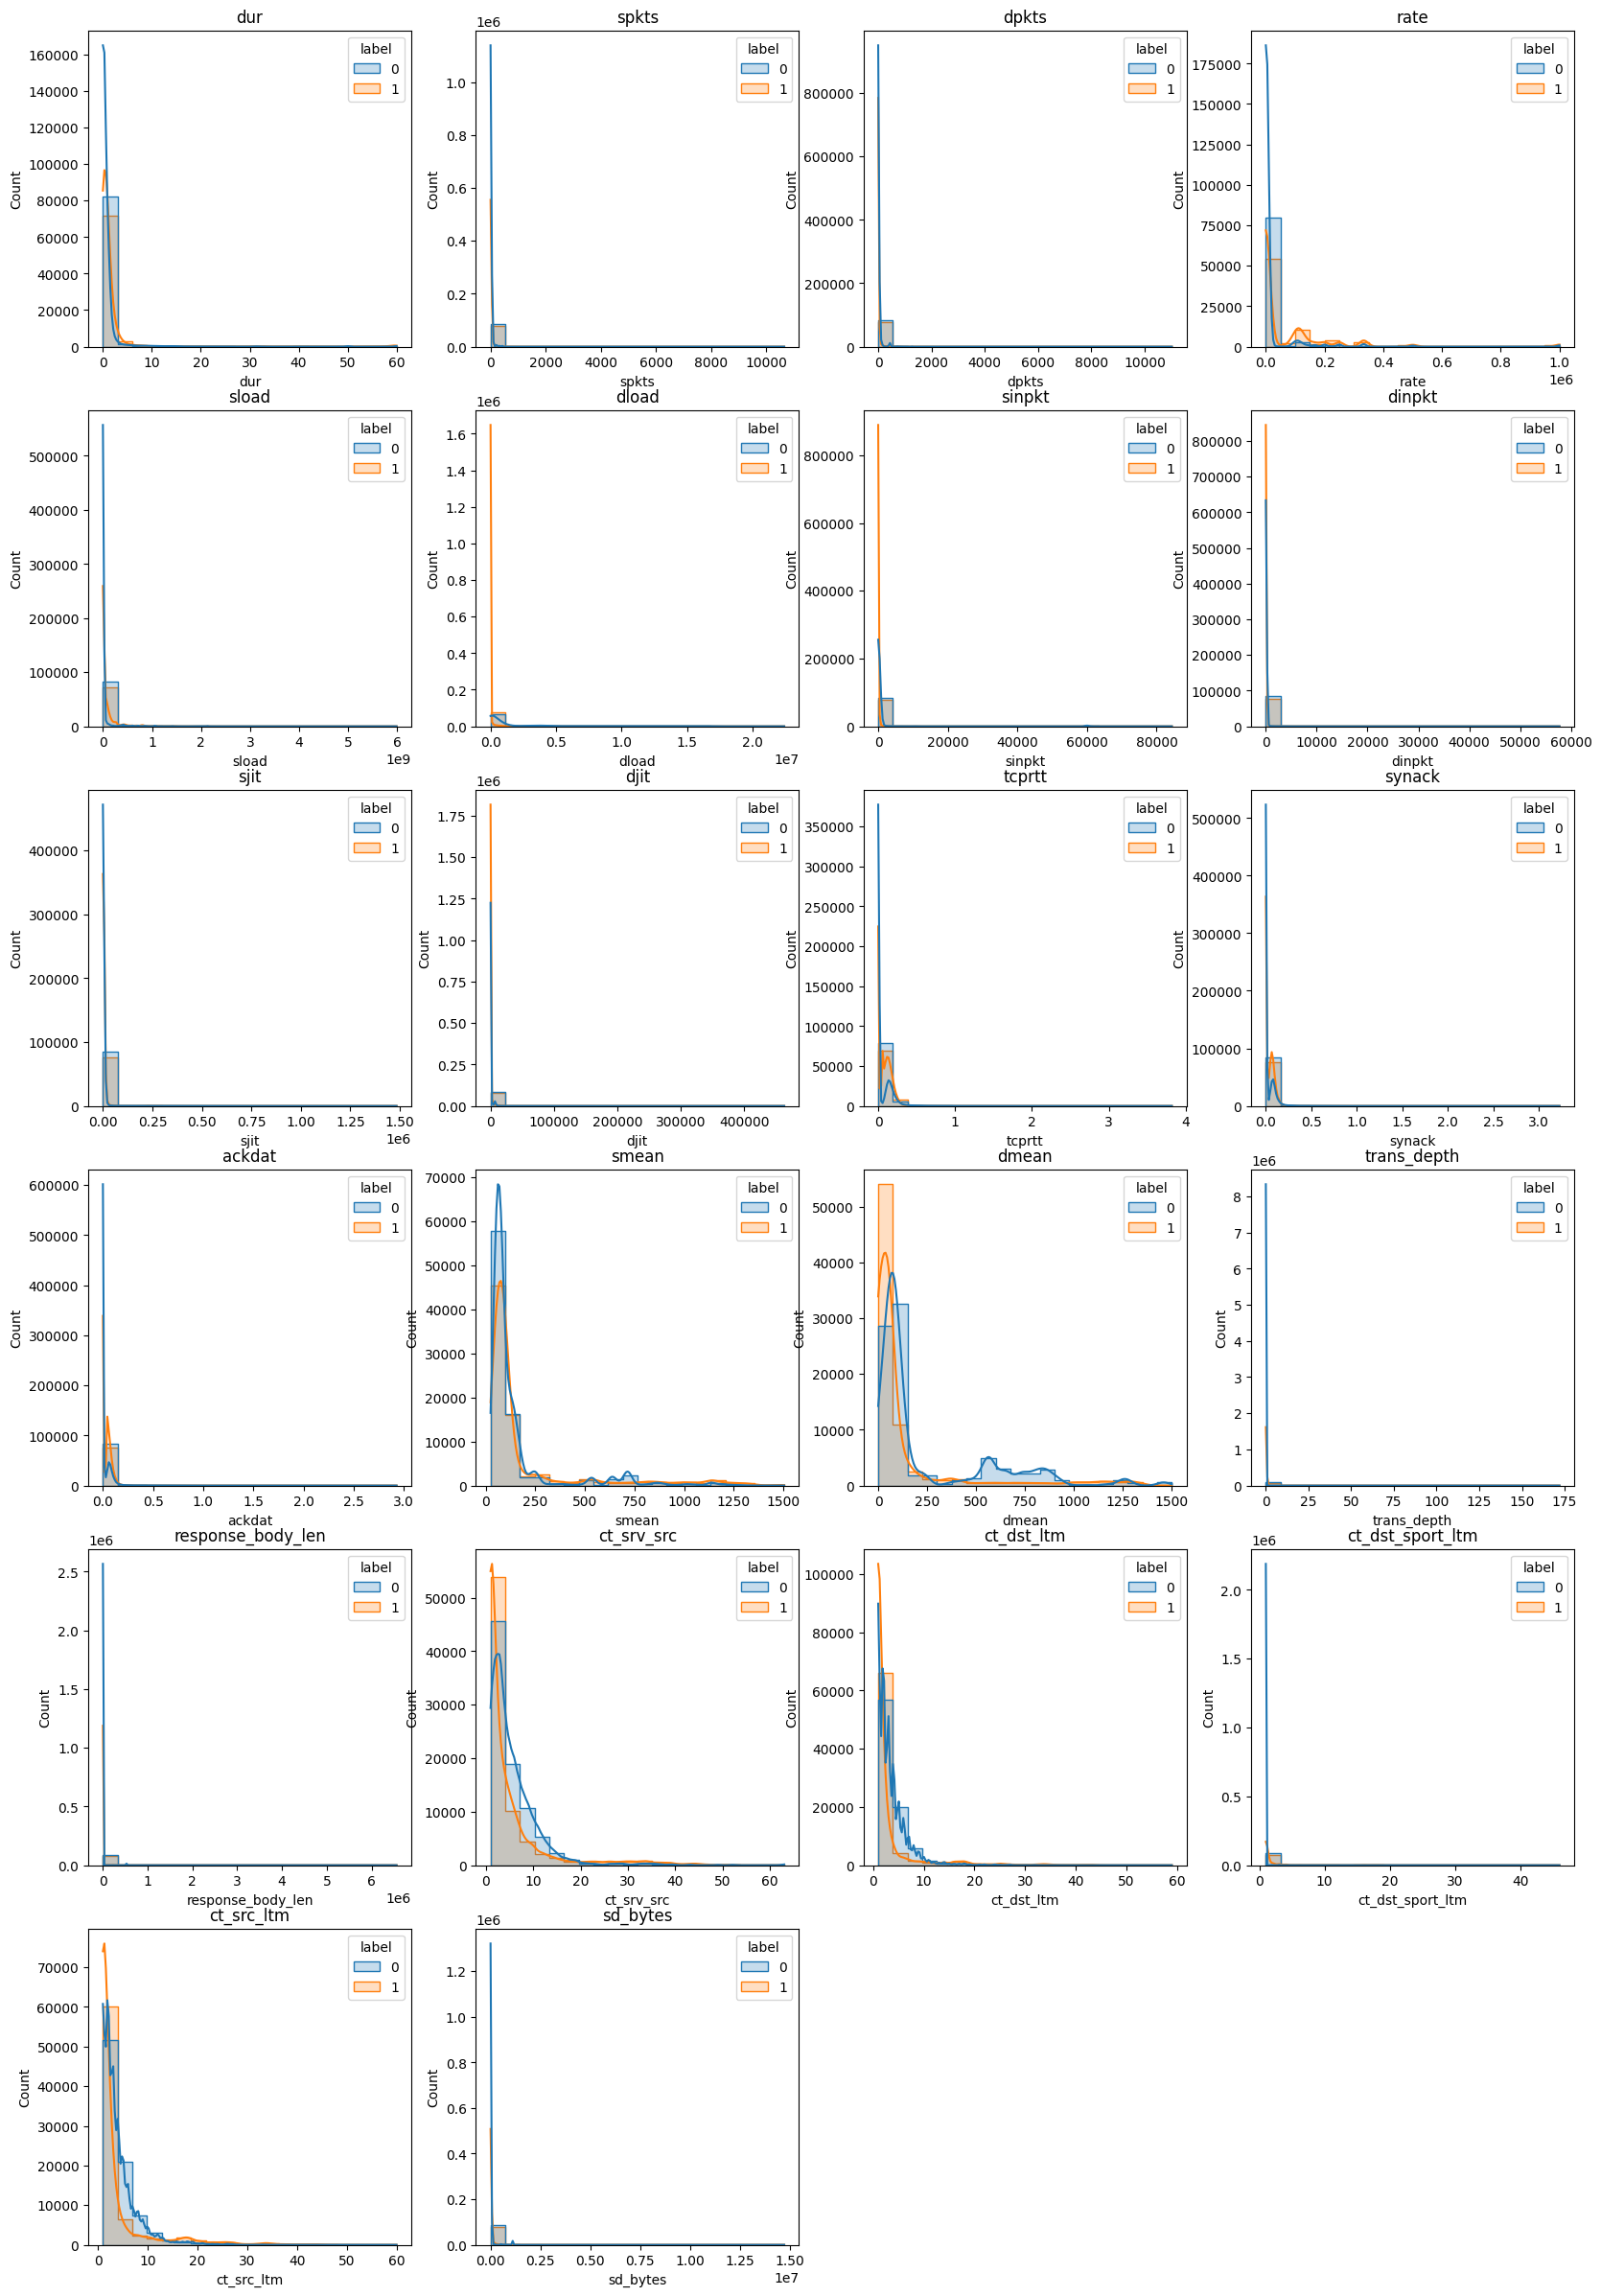

In [50]:
plot_data(*[{'data':data2, 'plt_type': 'hist', 'kde_flag':True, 'n_bins':20, 'col': c, 'hue': 'label'} for c in high_skewed_features_names])

Numerical skewed data after applying log1p

In [51]:
# Apply log1p to the specified columns
data2[high_skewed_features_names] = data2[high_skewed_features_names].apply(np.log1p)

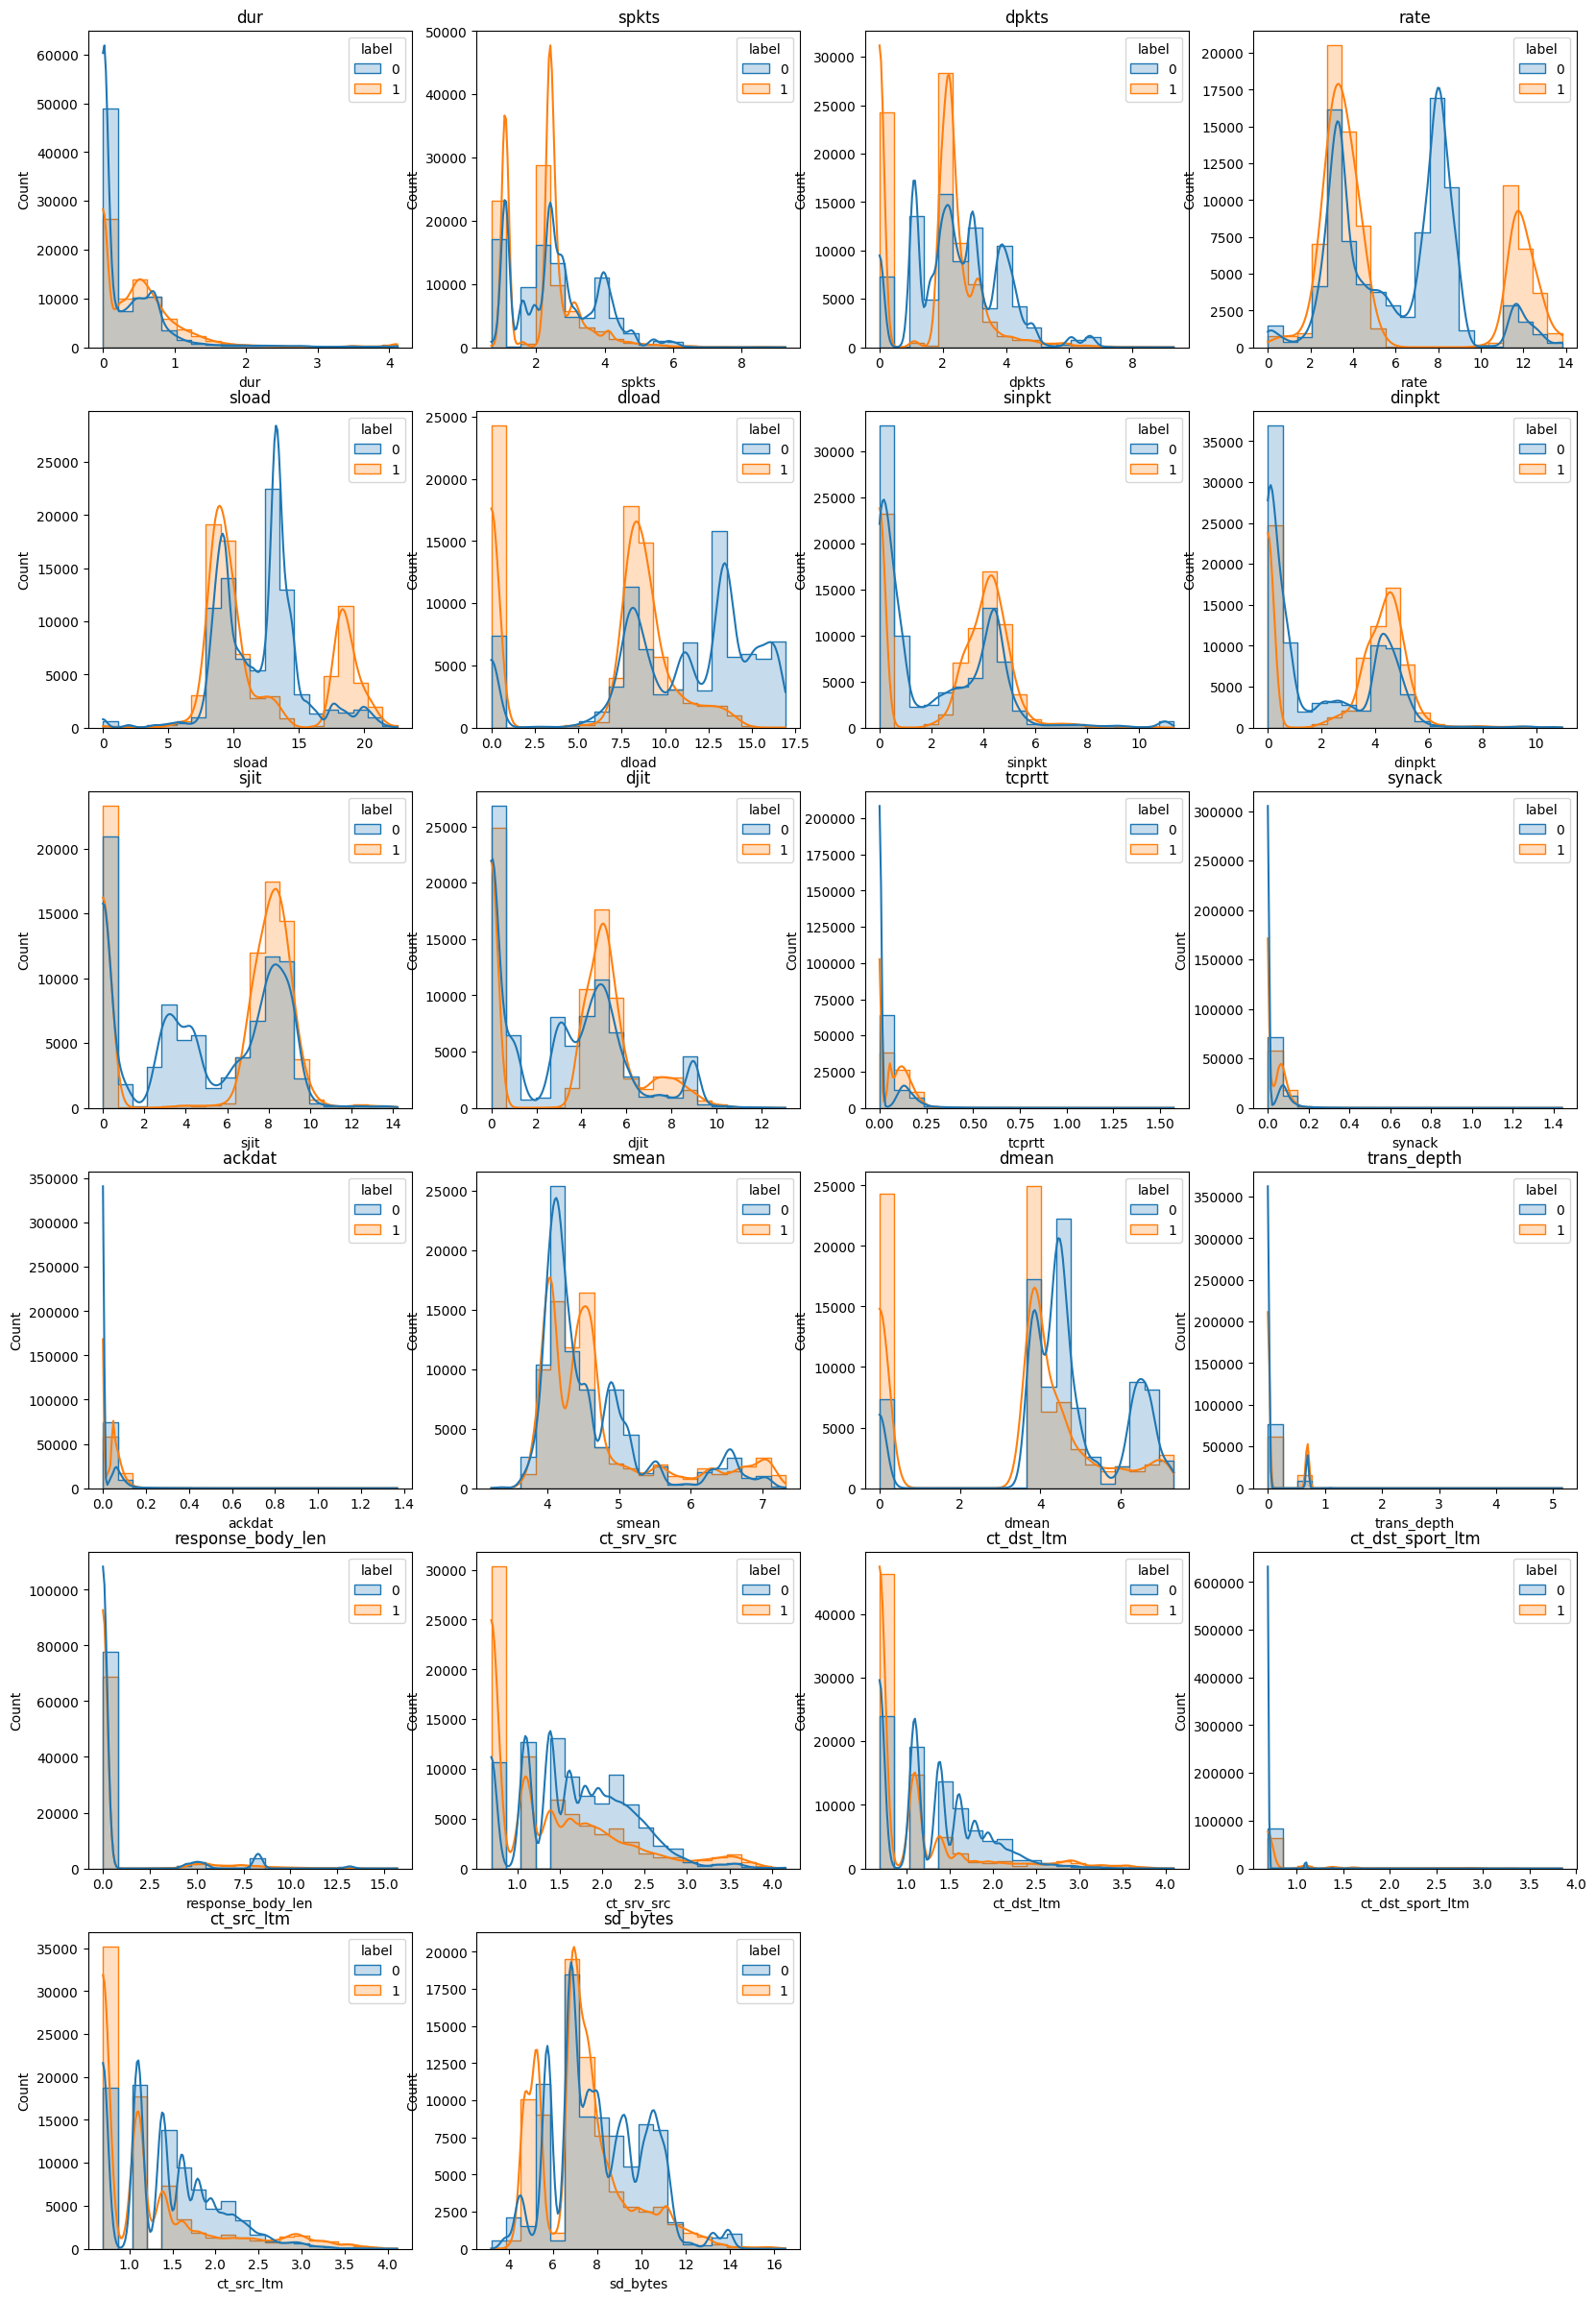

In [52]:
plot_data(*[{'data':data2, 'plt_type': 'hist', 'kde_flag':True, 'n_bins':20, 'col': c, 'hue': 'label'} for c in high_skewed_features_names])

# 7. Evaluation Metrics

### F1-Score
*  $F1 = \frac{2 \cdot Precision \cdot Recall}{Precision + Recall}$ <br>
* Harmonic mean of precision and recall
* Useful when you want to consider both false positives and false negatives

### Recall – True Positive Rate
* $Recall = \frac{True Positives}{True Positives + False Negatives}$ <br>
* Proportion of actual positive cases correctly predicted by model (hit rate)

### Precision – Positive Predictive Value
* $Precision = \frac{True Positives}{True Positives + False Porisitives}$ <br>
* Proportion of actual positive cases that are actually positive.

### Accuracy – Positive Predictive Value
* $Accuracy = \frac{True Positives + True Negatives}{Total Samples}$ <br>
* Overall correctness of the model

### ROC-AUC
* Range from 0 to 1 (0.5 – random match, 1 – perfect match)
* Higher value better performance
* ROC-AUC shows how well the classifier distinguish between 2 classes

# 8. Models

## Pipeline components

Pipeline includes:
- Pre-processing:
    - OneHotEncoder
        - Encodes categorical features
        - Allows to use ML models that require numeric input
        - Disadvantage – increasing dimensionality
    - StandardScaler
        - Applied for numerical features
        - standartize data with mean 0 and std 1, using formula
    $z = \frac{x - \mu}{\sigma}$ <br>
        - Advantage - better performance with scaled data
- Classifier models such as: LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, XGBClassifier, etc.
- Hyperparamater tuning using GridSearchCV

## 8. Binary Classification

In [53]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, precision_score, accuracy_score, f1_score, recall_score, average_precision_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [54]:
# Create a column transformer for preprocessing
def create_preprocessor(i_X_train, transf_names=None, remainder='drop', **kwargs):
    
    categorical_features = kwargs.get('cat_features', None)
    if not categorical_features:
        categorical_features = i_X_train.select_dtypes(include=['object']).columns.tolist()

    num_features = kwargs.get('num_features', None)
    if not num_features and categorical_features:
        num_features = ~i_X_train.columns.isin(categorical_features)

    #k = kwargs.get('k', None)
    tansformers_coll = []
    if transf_names is None:
        transf_names = ['cat', 'num'] if categorical_features else ['num']

    if 'vec' in transf_names:
        for v_params in kwargs.get('vectorizers'):
            v_name = v_params.get("name")
            vec_obj = v_params.get("vectorizer")
            text_features = v_params.get("cols")
            print(f'name: {v_name}, vec_obj: {type(vec_obj)}, text_features:{text_features}')
            tansformers_coll.append((v_name, vec_obj, text_features))

    if 'cat' in transf_names:
        tansformers_coll.append(('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features))
    
    if 'num' in transf_names:
        tansformers_coll.append(('num', StandardScaler(with_mean=False), num_features))   

    # Create a column transformer for preprocessing
    return ColumnTransformer(
        transformers=tansformers_coll, remainder=remainder)


def run_grid_search_cv(i_X_train, i_y_train, preprocessor, clf_params, cv_folds=5, i_X_test=None, i_y_test=None, pl_steps=None, n_jobs=-1, **gscv_kwargs):
    """
    Returns best models after GridSearchCV run
    :param preprocessor: data preprocessing. Example ColumnTransofrmer with OneHotEncoder and Scaler
    :param reg_params: dictionary with key - regressor name, value - dict with classifier params
    :param cv_folds: number of cross validation folds (default=5)
    """
    pl_steps = pl_steps if pl_steps else ['preprocessor', 'clf']
    best_estimators = {} # dict to store best estimator 
    # Run GridSearchCV for each classifier in the pipeline
    if 'scoring' not in gscv_kwargs:
        gscv_kwargs['scoring'] = 'r2'
    for clf_name, params in clf_params.items():
        reg_enable = params.get('enable', True)
        if reg_enable:
            print(f"Running {clf_name}")
            param_grid = params.get('param_grid', {})
            model_params = params.get('model_params', {})

            pl_elemets = []
            if 'preprocessor' in pl_steps:
                pl_elemets.append(('preprocessor', preprocessor))

            if 'clf' in pl_steps:
                pl_elemets.append(('clf', eval(clf_name)(**model_params)))
                
            # Create pipeline with pre-processor and classifier
            pl =  Pipeline(pl_elemets)
            
            # measure GridSearchCV execution time - start time
            sart_time = time.time()

            # create and run GridSearchCV
            display(pl)
            gscv = GridSearchCV(pl, param_grid, cv=cv_folds, n_jobs=n_jobs, return_train_score=False, **gscv_kwargs)
            gscv.fit(i_X_train, i_y_train)

            # measure GridSearchCV execution end time - start time
            end_time = time.time() - sart_time
            print(f'GridSearchCV for {clf_name} took {time.strftime("%M:%S", time.gmtime(end_time))}')

            # print best params and best score
            gscv_results = {}
            gscv_results['best params'] = gscv.best_params_

            print(f"{clf_name}=> {', '.join(f'{k}: {v}' for k, v in gscv_results.items())}")
            
            # store best estimator for future usage
            best_estimators[clf_name] = gscv.best_estimator_
    
    return best_estimators

def df_to_bar(df, x):
    x = x if x else 'classifier'
    n_rows = df.shape[0]
    plot_size_coef = 4
    ax = df.plot.bar(x='classifier', figsize=(plot_size_coef * n_rows, 6))
    # Add value labels on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 3), textcoords='offset points')


def evaluate_models(models, i_X_test, i_y_test, visualize=True, multiclass=False, **kwargs):
    cols = ['classifier', 'accuracy', 'precision', 'avg. precision', 'recall', 'macro avg. f1-score', 'roc-auc']
    if multiclass:
        cols = ['classifier', 'accuracy', 'macro avg. precision', 'macro avg. recall', 'macro avg. f1-score', 'macro avg. roc-auc']
    cv_res_data = {c:[] for c in cols}
    for clf_name, pipe_line in models.items():
        display(pipe_line['clf'])
        clf = pipe_line['clf']
        if 'selector' in pipe_line.named_steps:
            X_test_selected = pipe_line['selector'].transform(i_X_test)
            y_pred = clf.predict(X_test_selected)
        else:
            X_test_encoded = pipe_line['preprocessor'].transform(i_X_test)
            y_pred = clf.predict(X_test_encoded)           
        cv_res_data['classifier'].append(clf_name)

        cv_res_data['accuracy'].append(accuracy_score(i_y_test, y_pred))
        if multiclass:
            cv_res_data['macro avg. precision'].append(precision_score(i_y_test, y_pred, average='macro'))
            cv_res_data['macro avg. recall'].append(recall_score(i_y_test, y_pred, average='macro') )
            y_pred_prob = clf.predict_proba(X_test_encoded) 
            cv_res_data['macro avg. roc-auc'].append(roc_auc_score(i_y_test, y_pred_prob, multi_class='ovr', average='macro'))
        else:
            cv_res_data['precision'].append(precision_score(i_y_test, y_pred))
            cv_res_data['avg. precision'].append(average_precision_score(i_y_test, y_pred))
            cv_res_data['recall'].append(recall_score(i_y_test, y_pred))
            cv_res_data['roc-auc'].append(roc_auc_score(i_y_test, y_pred))
        cv_res_data['macro avg. f1-score'].append(f1_score(i_y_test, y_pred, average='macro'))

        if multiclass:
            print(123)
            le = kwargs.get('le')
            if le:
                print(f"{clf_name} classification report:\n{classification_report(i_y_test, y_pred,target_names=le.classes_)}")
    
    if visualize:
        cv_res_df = pd.DataFrame.from_dict(cv_res_data)
        df_to_bar(cv_res_df, x='classifier')
    
    return cv_res_df

def enable_models(model_collection, model_names=None, enable=True):
    if model_names is None:
        model_names = list(model_collection.keys())

    elif not isinstance(model_names, (list, tuple)):
        model_names = [model_names]
    
    for model_name in model_names:
        model_collection[model_name]['enable'] = enable

    print(f"Models {', '.join(mn for mn in model_names)} {'en' if enable else 'dis'}abled")

def update_model_params(model_collection, model_names=None, params=None, key='param_grid'):
    new_model_params = {}

    if model_names is None:
        model_names = list(model_collection.keys())

    elif not isinstance(model_names, (list, tuple)):
        model_names = [model_names]
    
    for model_name in model_names:
        new_model_params[model_name] = copy.deepcopy(model_collection[model_name])
        if params:
            if key in new_model_params[model_name]:
                new_model_params[model_name][key].update(params)
            else:
                 new_model_params[model_name][key] = params

    return new_model_params

In [55]:
models = {
    'LogisticRegression': {
        'param_grid': {
            'clf__C': np.logspace(-3, 2, 5),
            'clf__max_iter': [200, 500],
            'clf__penalty': [None, 'l2'],
            'clf__solver': ['lbfgs', 'saga']
            },
        'model_params': {
            'tol': 0.01,
            'max_iter': 15000 
        }
    },
    'DecisionTreeClassifier': {
        'param_grid': {
            'clf__max_depth': [3, 5, 7, 9]
            }},
    'RandomForestClassifier': {
        'param_grid': {
            'clf__n_estimators': [50, 100, 150],
            'clf__max_features': ['log2', 'sqrt']
            }},
    'SVC': {
        'param_grid': {
            'clf__C': np.logspace(-3, 2, 5),
            'clf__gamma': ['scale'],
            # 'clf__max_iter': [500, 1000],
            'clf__kernel': ['linear', 'rbf'],
        },
        'model_params': {
            'tol': 0.09,
            'max_iter': 10000
        }
    },
    'LinearSVC': {
        'param_grid': {
            'clf__C': np.logspace(-3, 2, 5)
        },
        'model_params': {
            'tol': 0.09,
            'max_iter': 10000,
            'dual': 'auto'
        }
    },
    'XGBClassifier': {
        'param_grid': {
            'clf__max_depth': [3, 5, 10]
        }
    },
    'SGDClassifier': {
        'param_grid': {
            'clf__alpha': np.logspace(-3, 2, 5), # learning rate
            'clf__loss': ['hinge'],
            'clf__penalty': ['l2'],
        },
        'model_params': {
            'max_iter': 1000
        }
    }
}

In [56]:
X = data2.drop(['label', 'attack_cat'], axis=1)  # data frame without target and non-useful features
y = data2['label']  # target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Models LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, SVC, LinearSVC, XGBClassifier, SGDClassifier disabled
Models LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, XGBClassifier, SGDClassifier enabled
Running LogisticRegression


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['proto', 'service',
                                                   'state']),
                                                 ('num',
                                                  StandardScaler(with_mean=False),
                                                  array([ True, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True]))])),
                ('clf', LogisticRegression(max_iter=15000, tol=0.01))])

c:\Users\sstas\.conda\envs\cyber_sec_3_11_9\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


GridSearchCV for LogisticRegression took 00:55
LogisticRegression=> best params: {'clf__C': 0.31622776601683794, 'clf__max_iter': 500, 'clf__penalty': None, 'clf__solver': 'saga'}
Running DecisionTreeClassifier


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['proto', 'service',
                                                   'state']),
                                                 ('num',
                                                  StandardScaler(with_mean=False),
                                                  array([ True, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True]))])),
                ('clf', DecisionTreeClassifier())])

GridSearchCV for DecisionTreeClassifier took 00:11
DecisionTreeClassifier=> best params: {'clf__max_depth': 9}
Running RandomForestClassifier


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['proto', 'service',
                                                   'state']),
                                                 ('num',
                                                  StandardScaler(with_mean=False),
                                                  array([ True, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True]))])),
                ('clf', RandomForestClassifier())])

GridSearchCV for RandomForestClassifier took 17:20
RandomForestClassifier=> best params: {'clf__max_features': 'sqrt', 'clf__n_estimators': 150}
Running XGBClassifier


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['proto', 'service',
                                                   'state']),
                                                 ('num',
                                                  StandardScaler(with_mean=False),
                                                  array([ True, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

GridSearchCV for XGBClassifier took 00:20
XGBClassifier=> best params: {'clf__max_depth': 5}
Running SGDClassifier


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['proto', 'service',
                                                   'state']),
                                                 ('num',
                                                  StandardScaler(with_mean=False),
                                                  array([ True, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True]))])),
                ('clf', SGDClassifier())])

GridSearchCV for SGDClassifier took 00:07
SGDClassifier=> best params: {'clf__alpha': 0.001, 'clf__loss': 'hinge', 'clf__penalty': 'l2'}


LogisticRegression(C=0.31622776601683794, max_iter=500, penalty=None,
                   solver='saga', tol=0.01)

c:\Users\sstas\.conda\envs\cyber_sec_3_11_9\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


DecisionTreeClassifier(max_depth=9)

c:\Users\sstas\.conda\envs\cyber_sec_3_11_9\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


RandomForestClassifier(n_estimators=150)

c:\Users\sstas\.conda\envs\cyber_sec_3_11_9\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

c:\Users\sstas\.conda\envs\cyber_sec_3_11_9\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SGDClassifier(alpha=0.001)

c:\Users\sstas\.conda\envs\cyber_sec_3_11_9\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


classifier  accuracy  precision  avg. precision    recall  \
0      LogisticRegression  0.857866   0.812596        0.782020  0.909775   
1  DecisionTreeClassifier  0.874972   0.886714        0.822238  0.843883   
2  RandomForestClassifier  0.907808   0.903677        0.861314  0.901473   
3           XGBClassifier  0.909971   0.908986        0.865491  0.900073   
4           SGDClassifier  0.851107   0.765169        0.762053  0.989312   

   macro avg. f1-score   roc-auc  
0             0.857864  0.860459  
1             0.874256  0.873420  
2             0.907541  0.907492  
3             0.909676  0.909477  
4             0.849993  0.858010

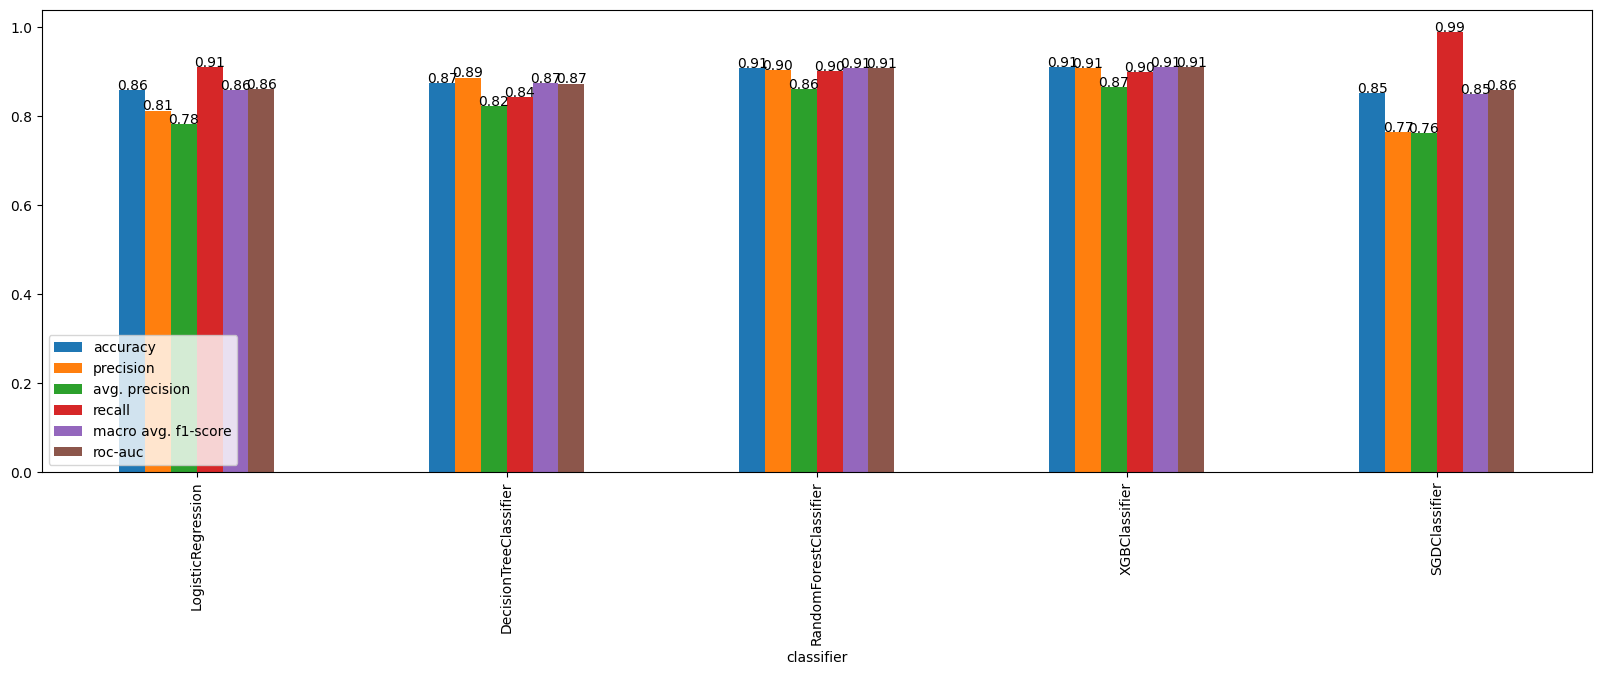

In [57]:
enable_models(models, enable=False)
enable_models(models, ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'XGBClassifier', 'SGDClassifier'], enable=True)
#enable_models(models, ['XGBClassifier'], enable=True)

# create preprocessor with columns transformers 
preprocessor_1 = create_preprocessor(X_train, transf_names=['cat', 'num'], remainder='passthrough')

# run GridSearchCV
gscv_kwargs = {}
best_models_1 = run_grid_search_cv(X_train, y_train, preprocessor=preprocessor_1, clf_params=models, cv_folds=5, i_X_test=X_train, i_y_test=y_test, **gscv_kwargs)

# evaluate results
evaluate_models(best_models_1, X_test, y_test)

In [58]:
def plot_model_feature_importance(pipe_lines, model_name, fig_size=(12,6)):
    pl = pipe_lines[model_name]
    clf_model = pl['clf']
    cp = sns.color_palette()
    num_non_zero_features=np.count_nonzero(clf_model.feature_importances_)
    print(f'visualize_feature_importance: Model {model_name} - number of non-zero important features is {num_non_zero_features}')
    
    indices = np.argsort(-1 * abs(clf_model.feature_importances_))[:num_non_zero_features]
    plt.figure(figsize=fig_size)
    plt.bar(pl[:-1].get_feature_names_out()[indices], abs(clf_model.feature_importances_[indices]), color=cp)
    plt.xticks(rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.title(f"{model_name} feature importance")
    plt.grid()
    plt.show()

visualize_feature_importance: Model XGBClassifier - number of non-zero important features is 46


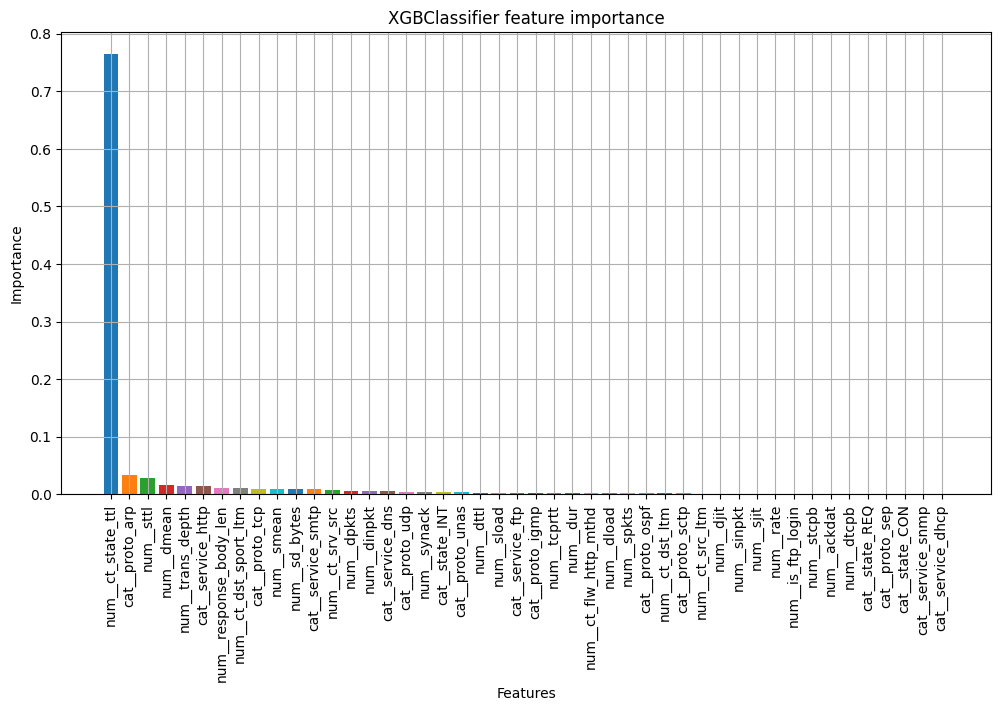

In [59]:
plot_model_feature_importance(best_models_1, model_name='XGBClassifier')

## Muliclass Classification

**Note**: To save time will execute only XGBClassifier

In [60]:
X = data2.drop(['label', 'attack_cat'], axis=1)  # data frame without target and non-useful features
y = data2['attack_cat']  # target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [61]:
m_params = {
    'objective': 'multi:softmax',
    'num_class': len(np.unique(y)),
}

In [62]:
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc, le

In [63]:
y_train_enc, y_test_enc, le = prepare_targets(y_train, y_test)

In [64]:
tgt_features = ['attack_cat']
multiclass_params = update_model_params(models, 'XGBClassifier', params=m_params, key='model_params')
enable_models(multiclass_params, 'XGBClassifier', enable=True)

# create preprocessor with columns transformers 
preprocessor_2 = create_preprocessor(X_train, transf_names=['cat', 'num'], remainder='passthrough')

# run GridSearchCV
gscv_kwargs = {}
best_models_2 = run_grid_search_cv(X_train, y_train_enc, preprocessor=preprocessor_2, clf_params=multiclass_params, cv_folds=5, i_X_test=X_train, i_y_test=y_test_enc, **gscv_kwargs)



Models XGBClassifier enabled
Running XGBClassifier


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['proto', 'service',
                                                   'state']),
                                                 ('num',
                                                  StandardScaler(with_mean=False),
                                                  array([ True, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None, num_class=10,
                               num_parallel_tree=None, ...))])

GridSearchCV for XGBClassifier took 01:23
XGBClassifier=> best params: {'clf__max_depth': 3}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=10,
              num_parallel_tree=None, ...)

c:\Users\sstas\.conda\envs\cyber_sec_3_11_9\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


123
XGBClassifier classification report:
                precision    recall  f1-score   support

      Analysis       0.17      0.12      0.14       534
      Backdoor       0.36      0.09      0.14       450
           DoS       0.31      0.15      0.20      1325
      Exploits       0.76      0.83      0.79      6879
       Fuzzers       0.59      0.54      0.57      5235
       Generic       0.98      0.83      0.90      1914
        Normal       0.88      0.93      0.91     21413
Reconnaissance       0.78      0.78      0.78      2543
     Shellcode       0.58      0.52      0.55       350
         Worms       0.56      0.57      0.56        44

      accuracy                           0.80     40687
     macro avg       0.60      0.54      0.55     40687
  weighted avg       0.78      0.80      0.79     40687



classifier  accuracy  macro avg. precision  macro avg. recall  \
0  XGBClassifier  0.802345              0.597795            0.53667   

   macro avg. f1-score  macro avg. roc-auc  
0              0.55422            0.972594

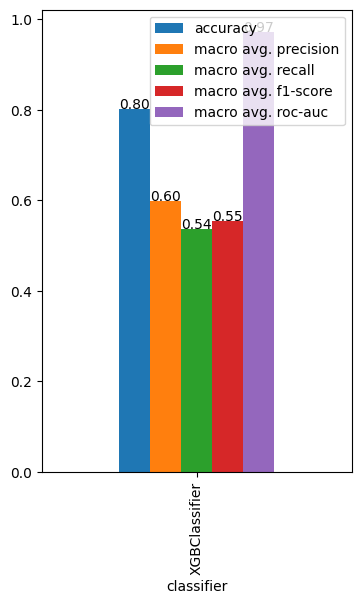

In [65]:
# evaluate results
evaluate_models(best_models_2, X_test, y_test_enc, multiclass=True, le=le)

# 9. References

1. Nour Moustafa, Jill Slay. ["UNSW-NB15: A Comprehensive Data set for Network Intrusion Detection systems"](https://www.researchgate.net/publication/287330529_UNSW-NB15_a_comprehensive_data_set_for_network_intrusion_detection_systems_UNSW-NB15_network_data_set)<br>
<i>Military Communications and Information Systems Conference (MilCIS), 2015. IEEE, 2015</i>
2. Nour Moustafa, Jill Slay. ["The evaluation of Network Anomaly DetectionSystems: Statistical analysis of the UNSW-NB15 data set and the comparison with the KDD99 dataset"](https://www.researchgate.net/publication/290061926_The_evaluation_of_Network_Anomaly_Detection_Systems_Statistical_analysis_of_the_UNSW-NB15_data_set_and_the_comparison_with_the_KDD99_data_set)<br>
<i>Information Security Journal: A Global Perspective (2016)</i>
3. Shweta More, Moad Idrissi, Haitham Mahmoud and A. Tauﬁq Asyhari ["Enhanced Intrusion Detection Systems Performance with UNSW-NB15 Data Analysis"](https://www.researchgate.net/publication/377915801_Enhanced_Intrusion_Detection_Systems_Performance_with_UNSW-NB15_Data_Analysis)<br>
<i>Faculty of Computing, Birmingham City University and Department of Data Science, Monash University, Indonesia. February 2024</i>
4. Zeinab Zoghi, Gursel Serpen. ["UNSW-NB15 computer security dataset: Analysis through visualization"](https://arxiv.org/pdf/2101.05067)<br>
<i>Electrical Engineering & Computer Science, University of Toledo, Ohio, USA, Indonesia. 13 Jan 2021</i>
5. Md. Khairul Islam, Prithula Hridi, Md. Shohrab Hossain, Husnu S. Narman ["Network Anomaly Detection Using LightGBM: A Gradient Boosting Classiﬁer"](https://www.researchgate.net/publication/349170805_Network_Anomaly_Detection_Using_LightGBM_A_Gradient_Boosting_Classifier)<br>
<i>Department of Computer Science and Engineering, Bangladesh University of Engineering and Technology, Bangladesh<br>
Weisberg Division of Computer Science, Marshall University, Huntington, WV, USA.<br>
November 2020</i>
6. ["Network Intrusion Detection Using Logistic Regression and K-Nearest Neighbour Using UNSW_NB15 dataset"](https://rpubs.com/ken_iyke/1017857)<br>
<i>By Kenneth Nnadi, RPubs, 20 march, 2023</i>
7. ["Building an Intrusion Detection System on UNSW-NB15 Dataset Based on Machine Learning Algorithm"](https://medium.com/@subrata.maji16/building-an-intrusion-detection-system-on-unsw-nb15-dataset-based-on-machine-learning-algorithm-16b1600996f5)<br>
<i> By Subrata Maji. Medium, Sep 19, 2020</i>
8. ["Understanding np.log and np.log1p in NumPy"](https://medium.com/@noorfatimaafzalbutt/understanding-np-log-and-np-log1p-in-numpy-99cefa89cd30)<br>
<i> By Noor Fatima. Medium, Jun 28, 2024
9. ["All about Feature Selection"](https://medium.com/@chandradip93/all-about-feature-selec-e6e88e8ccd46)<br>
<i>By Chandradip Banerjee, Medium, Mar 6 2023</i>
10. ["Why we have to remove highly correlated features in Machine Learning?"](https://medium.com/@sujathamudadla1213/why-we-have-to-remove-highly-correlated-features-in-machine-learning-9a8416286f18)<br>
<i>By Sujatha Mudadla, Medium, Nov 29, 2023</i>
11. ["Pearson Correlation Coefficient (r) | Guide & Examples"](https://www.scribbr.com/statistics/pearson-correlation-coefficient/) <br>
<i>Scribbr, Published on May 13, 2022 by Shaun Turney. Revised on February 10, 2024</i>
12. ["Correlation in machine learning — All you need to know"](https://medium.com/@abdallahashraf90x/all-you-need-to-know-about-correlation-for-machine-learning-e249fec292e9)<br>
<i>By Abdallah Ashraf, Medium, Sep 22 2023</i>
13. ["Kurtosis() & Skew() Function In Pandas"](https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de)<br>
<i>By Atanu Dan, Medium, Sep 15 2020</i>
14. ["What Is Kurtosis? | Definition, Examples & Formula"](https://www.scribbr.com/statistics/kurtosis/)<br>
<i>Scribbr, by Shaun Turney, published on June 27, 2022, revised on Jan 29, 2024.</i>
15. ["Median"](https://en.wikipedia.org/wiki/Median). <i>Wikipedia</i>
16. ["Mean"](https://en.wikipedia.org/wiki/Mean). <i>Wikipedia</i>
17. ["Standard deviation"](https://en.wikipedia.org/wiki/Standard_deviation). <i>Wikipedia</i>
18. ["Skewness"](https://en.wikipedia.org/wiki/Skewnessn). <i>Wikipedia</i>